# HH 

## To do

- Check GEN,reco matching criteria, dR, dpt
- L1 jet pt efficiency
- L1 tau pt efficiency
- b-tagging efficiency
- Signal efficiency vs jet rank
- ...

## Imports

In [68]:
# # %pip install uproot awkward numpy particle vector networkx matplotlib
# print()
# print("###############")
# print("conda packages:")
# print("###############")
# print()
# %conda list uproot
# %conda list awkward
# %conda list numpy
# %conda list particle
# %conda list vector
# %conda list networkx
# %conda list matplotlib
# print()
# print("#############")
# print("pip packages:")
# print("#############")
# print()
# %pip show uproot awkward numpy particle vector networkx matplotlib

In [69]:
import sys
import uproot
import awkward as ak
import numpy as np
from particle import Particle
import networkx as nx
import matplotlib.pyplot as plt
import vector
vector.register_awkward()
np.set_printoptions(linewidth=120)
from types import MappingProxyType as immutable_dict # immutable dictionary
import copy
import numpy as np
import matplotlib.pyplot as plt
import hist
from hist import Hist
from scipy import stats
import mplhep as hep
hep.style.use("CMS")


## Common

### Settings

In [70]:
# DEBUG MODE
debug = False

settings_ = immutable_dict({
    # Misc
    "debug":debug, 
    "nevents":10000 if not debug else 1,
    "skip":0 if not debug else 315,
    "verbosity":0 if not debug else 2,
    # Kinematic thresholds
    "gen_pt_min":10.,
    "gen_eta_max":2.5,
    "off_pt_min":35.,
    "off_eta_max":2.5,
    "off_btag_min":0.55,
    "sct_pt_min":10.,
    "sct_eta_max":2.5,
    # Use only di-tau trigger, ParkingHH trigger, or the OR of both
    "option":["tautau","bb","bbtautau"][2],
    # Match L1 and HLT objects to GEN
    "use_matched":False,
})


### GEN

In [71]:
#############################################################################################
#
def get_particle_name(pdg_id):
    try:
        return f"{Particle.from_pdgid(pdg_id).name}, {pdg_id}"
    except:
        return f"Unknown ({pdg_id})"

#############################################################################################
#    
def print_gen(event):

    for i in range(len(event["gen__pdgId"])):
        pdg_id = event["GenPart_pdgId"][i]
        mother_idx = event["GenPart_genPartIdxMother"][i]
        
        particle_name = get_particle_name(pdg_id)
        mother_name = get_particle_name(event["GenPart_pdgId"][mother_idx]) if mother_idx >= 0 else "None"
        
        eta = event["GenPart_eta"][i]
        phi = event["GenPart_phi"][i]
        
        print(f"  Particle: {particle_name} (PDG ID: {pdg_id})")
        print(f"    Mother: {mother_name}")
        print(f"    eta: {eta:.2f}, phi: {phi:.2f}")

#############################################################################################
# Function to recursively build the decay hierarchy
def build_decay_graph(events,idx):

    pdgId = events.GenPart_pdgId[idx]
    motherIdx = events.GenPart_genPartIdxMother[idx]

    # Create a directed graph to represent the hierarchy
    G = nx.DiGraph()

    for idx, pid in enumerate(pdgId):
        # Get particle name if possible, otherwise use PDG ID
        try:
            particle_name = f"{Particle.from_pdgid(pid).name}, {pid}"
        except Exception:
            particle_name = f"PDG: {pid} (idx: {idx})"
        
        # Add the particle as a node
        G.add_node(idx, label=particle_name)
        
        # Connect to the mother particle
        mother = motherIdx[idx]
        if mother >= 0:  # Valid mother index
            G.add_edge(mother, idx)
    
    return G

#############################################################################################
# Export the decay hierarchy to a structured text format
def print_hierarchy(G, node, depth=0):
    label = G.nodes[node]["label"]
    indent = "  " * depth
    print(f"{indent}{label}")
    for child in G.successors(node):
        print_hierarchy(child, depth + 1)

#############################################################################################
# Function to export the decay hierarchy to text
def export_decay_hierarchy_to_text(G):
    # Find the root nodes (particles without mothers)
    roots = [node for node in G.nodes if G.in_degree(node) == 0]
    for root in roots:
        print_hierarchy(G, root)

#############################################################################################
#
def print_decay_graph(events,idx):
    G = build_decay_graph(events,idx)
    print(f"--- Decay Hierarchy for Event {idx} ---")
    export_decay_hierarchy_to_text(G)


### Print

In [72]:
#############################################################################################
#
def print_summary(
    events,
    passed_GEN=None,
    passed_L1T=None,
    matched_L1T=None,
    passed_HLT=None,
    matched_HLT=None,
    matched_OFF=None,
    matched_SCT=None,
    use_matched=False,
    ):

    passed_tot = ak.ones_like(events["nGenPart"])
    if passed_GEN is None: passed_GEN = ak.ones_like(passed_tot)
    if passed_L1T is None: passed_L1T = ak.ones_like(passed_tot)
    if matched_L1T is None: matched_L1T = ak.ones_like(passed_tot)
    if passed_HLT is None: passed_HLT = ak.ones_like(passed_tot)
    if matched_HLT is None: matched_HLT = ak.ones_like(passed_tot)
    if matched_OFF is None: matched_OFF = ak.ones_like(passed_tot)
    if matched_SCT is None: matched_SCT = np.ones_like(passed_tot)

    tot = passed_tot
    acc = tot&passed_GEN
    l1t = acc&passed_L1T&matched_L1T if use_matched else acc&passed_L1T
    hlt = l1t&passed_HLT&matched_HLT if use_matched else l1t&passed_HLT
    off = hlt&matched_OFF
    sct = passed_GEN&matched_SCT

    tot = np.sum(tot)
    acc = np.sum(acc)
    l1t = np.sum(l1t)
    hlt = np.sum(hlt)
    off = np.sum(off)
    sct = np.sum(sct)

    print()
    print("==================================")
    print(f"              Events    Eff   Gain")
    print("==================================")
    print("STANDARD (W/ matching @ L1 & HLT)" if use_matched else "STANDARD (No matching @ L1 & HLT)")
    print(f"Inclusive     {tot:6.0f} ")
    print(f"Acceptance    {acc:6.0f} {acc/tot:6.2f} {sct/acc:6.2f}")
    print(f"L1T           {l1t:6.0f} {l1t/tot:6.2f} {sct/l1t:6.2f}")
    print(f"HLT           {hlt:6.0f} {hlt/tot:6.2f} {sct/hlt:6.2f}")
    print(f"Offline       {off:6.0f} {off/tot:6.2f} {sct/off:6.2f}")
    print("----------------------------------")
    print("SCOUTING")
    print(f"Inclusive     {tot:6.0f}")
    print(f"Acceptance    {acc:6.0f} {acc/tot:6.2f}")
    print(f"Scouting      {sct:6.0f} {sct/tot:6.2f}")
    print("==================================")

#############################################################################################
#
def print_matching_base(x):
    if "match" not in x.fields or x.match is None: x["match"] = False #@@ Needed?
    if "dr" not in x.fields or x.dr is None: x["dr"] = 9.99 #@@ Needed?
    if "idx" not in x.fields or x.idx is None: x["idx"] = -1 #@@ Needed?
    if "id" not in x.fields or x.id is None: x["id"] = -1 #@@ Needed?
    pad = " "*6
    basic = f"pt: {x.pt:5.1f}, eta: {x.eta:5.2f}, phi: {x.phi:5.2f}, id: {x.id:2.0f}"
    match = f", dr: {x.dr:4.2f}, idx: {x.idx:2.0f}, match: {x.match:1.0f}"
    return pad+basic+match

#############################################################################################
#
def print_matching(gen,obj):
    if obj is None: #@@ dirty hack to broadcast to event-level if obj=None
        obj = ak.full_like(ak.num(gen,1),False,dtype=bool)
        obj = ak.mask(obj,obj,valid_when=True)
    for idx,(gen_,obj_) in enumerate(zip(gen,obj)):
        if gen_ is None and obj_ is None: continue
        print(f"  Event {idx}:")
        print("    GEN:")
        if gen_ is None: gen_ = []
        for x in gen_:
            if x is None: continue
            base = print_matching_base(x)
            # if x.id is None: x["id"] = -1 #@@ Needed?
            # print(f"      pt: {x.pt:5.1f}, eta: {x.eta:5.2f}, phi: {x.phi:5.2f}, id: {x.id:2.0f}, status: {x.status:.0f}, last_copy: {x.last_copy:.0f}")
            status = f", status: {x.status:.0f}, last_copy: {x.last_copy:.0f}"
            print(base+status)
        print("    OBJ:")
        if obj_ is None or obj_ is False: obj_ = []
        for x in obj_:
            if x is None: continue
            base = print_matching_base(x)
            # if x.match is None: x["match"] = False #@@ Needed?
            # if x.dr is None: x["dr"] = 9.99 #@@ Needed?
            # if x.idx is None: x["idx"] = -1 #@@ Needed?
            # if x.id is None: x["id"] = -1 #@@ Needed?
            # pad = " "*6
            # basic = f"pt: {x.pt:5.1f}, eta: {x.eta:5.2f}, phi: {x.phi:5.2f}, dr: {x.dr:4.2f}, id: {x.id:2.0f}"
            # match = f", idx: {x.idx:2.0f}, match: {x.match:1.0f}"
            # base=pad+basic+match
            trg = ""
            if "bits_ok" in x.fields: trg += f", bits_ok: {x.bits_ok if x.bits_ok is not None else -1:2.0f}"
            #if "bits"    in x.fields: trg += f", bits: {x.bits if x.bits is not None else 0:>032b}"
            if "bits"    in x.fields: 
                bits_list, = np.where([x.bits >> i & 1 for i in range(32)]) # comma dereferences the tupl(np.array,)
                bits_list = ", ".join([f'{x:.0f}' for x in bits_list])
                trg += f", bits: {bits_list}"
            print(base+trg)


### Filters

In [73]:
#############################################################################################
#
def filter_events(events,passed):
    if passed is not None:
        events = ak.mask(events,passed)
    return events

### Objects

In [74]:
#############################################################################################
#
def objects(events,**kwargs):
    obj = {}
    for key,val in kwargs.items():
        if type(val) is str:
            obj[key] = events[val]
        else:
            obj[key] = val
    obj = ak.zip(obj)
    return obj

#############################################################################################
#
def base_objects(events,label,id=None):
    kwargs = {
        "pt":f"{label}_pt", "eta":f"{label}_eta", "phi":f"{label}_phi", # Kine
    }
    if id is not None:  kwargs["id"] = ak.full_like(events[f"{label}_pt"],id)
    return objects(events,**kwargs)

#############################################################################################
#
def gen_objects(events):
    gen = base_objects(events,label="GenPart")
    gen["id"] = abs(events["GenPart_pdgId"])
    gen["mother_idx"] = events["GenPart_genPartIdxMother"]
    gen["mother_id"] = abs(gen.id[gen.mother_idx])
    gen["status"] = events["GenPart_statusFlags"]

    # https://github.com/cms-sw/cmssw/blob/master/DataFormats/HepMCCandidate/interface/GenStatusFlags.h

    # Is particle prompt (not from hadron, muon, or tau decay)
    gen["is_prompt"] = (gen.status & (1 << 0) != 0)
    # This particle is part of the hard process
    gen["is_hard_process"] = (gen.status & (1 << 7) != 0)
    # This particle is the direct descendant of a hard process particle of the same pdg id
    gen["from_hard_process"] = (gen.status & (1 << 8) != 0)
    # This particle is the first copy of the particle in the chain with the same pdg id
    gen["first_copy"] = (gen.status & (1 << 12) != 0)
    # This particle is the last copy of the particle in the chain with the same pdg id
    gen["last_copy"] = (gen.status & (1 << 13) != 0)

    return gen

#############################################################################################
#
def jet_objects(events):
    jet = base_objects(events,label="Jet",id=1)
    jet["btag"] = events["Jet_btagPNetB"]
    return jet

#############################################################################################
#
def tau_objects(events):
    return base_objects(events,label="Tau",id=15)

#############################################################################################
#
def muon_objects(events):
    muon = base_objects(events,label="Muon",id=13)
    muon["dxy"] = events["Muon_dxy"]
    muon["dxyerr"] = events["Muon_dxyErr"]
    muon["dxysig"] = muon.dxy/muon.dxyerr
    return muon

#############################################################################################
#
def L1Jet_objects(events):
    return base_objects(events,label="L1Jet",id=1)

#############################################################################################
#
def L1DJet_objects(events):
    jet = base_objects(events,label="L1DisplacedJet",id=1)
    jet["btag"] = events["L1DisplacedJet_btagScore"]
    return jet

#############################################################################################
#
def L1Tau_objects(events):
    return base_objects(events,label="L1Tau",id=15)

#############################################################################################
#
def L1TauP2_objects(events):
    return base_objects(events,label="L1GTnnTau",id=15)

#############################################################################################
#
def HLT_objects(events):
    hlt = base_objects(events,label="TrigObj")
    hlt["id"] = events["TrigObj_id"]
    hlt["bits"] = events["TrigObj_filterBits"]
    return hlt

#############################################################################################
#
def L1Mu_objects(events):
    muon = base_objects(events,label="L1Mu",id=13)
    muon["qual"] = events["L1Mu_hwQual"]
    muon["etaAtVtx"] = events["L1Mu_etaAtVtx"]
    muon["phiAtVtx"] = events["L1Mu_phiAtVtx"]
    return muon


### Matching

In [75]:
#############################################################################################
#
def delta_phi(x):
    """Normalize phi angle to [-π, π]."""
    return (x + np.pi) % (2 * np.pi) - np.pi

#############################################################################################
#
def geometric_matching_base(gen,obj,direction="reco_to_gen",dr_max=0.3,dpt_min=0.2,dpt_max=2.0,verbosity=0):

    # Pairs: all possible pairs of objects of type x and y (x = outer loop, y = inner loop)
    # e.g. [(x1,y1), (x1,y2), (x2,y1), (x2,y2), ...] 
    # "gen_to_reco" matching is where x = gen and y = obj
    # "reco_to_gen" matching is where x = obj and y = gen

    pairs = None
    if    direction == "reco_to_gen": pairs = ak.cartesian([obj, gen], nested=True) 
    elif  direction == "gen_to_reco": pairs = ak.cartesian([gen, obj], nested=True) 
    else: raise ValueError(f'[geometric_matching_base] Unknown direction "{direction}"')
    # print("pairs",pairs)

    # Unzip the pairs to get the reco and GEN objects separately and calc dPt, dEta, dPhi, dR
    pairs_y, pairs_x = ak.unzip(pairs)
    dpt  = pairs_y.pt / pairs_x.pt if direction == "reco_to_gen" else pairs_x.pt / pairs_y.pt
    deta = pairs_y.eta - pairs_x.eta
    dphi = delta_phi(pairs_y.phi - pairs_x.phi)
    dr   = np.sqrt(deta**2 + dphi**2)

    #@@ Consider both geometric and pT matching ???
    #dr = np.sqrt(dr**2 + (dpt-1.)**2)

    # Defined dr_none, used as a dummy value in case of None, as a large value (dr_none > dr_max)
    dr_none = 9.99 # Better than 10. for formatting purposes in print_matching()

    # Apply pT matching criteria if required
    if dpt_min is not None: dr = ak.mask(dr,dpt > dpt_min)
    if dpt_max is not None: dr = ak.mask(dr,dpt < dpt_max)
    dr = ak.fill_none(dr,dr_none) # Set masked entries to dummy value

    # For each reco object, sort the GEN objects by dR
    dr_sort = ak.sort(dr,axis=-1)
    dr_min = ak.firsts(dr_sort,axis=-1)

    # Get the index of the reco object with the lowest dR
    dr_min_sort = ak.argsort(dr,axis=-1)
    dr_min_idx = ak.firsts(dr_min_sort,axis=-1)

    # Identify matches if smallest dR is less than the maximum allowed value
    matched = (dr_min is not None) & (dr_min < dr_max)

    # Mask out unmatched values for both dR and the index
    dr_min = ak.mask(dr_min,matched)
    dr_min_idx = ak.mask(dr_min_idx,matched)

    # Replace None values with False
    matched = ak.fill_none(matched,False)
    dr_min = ak.fill_none(dr_min,dr_none)
    dr_min_idx = ak.fill_none(dr_min_idx,-1)

    # Store the results in the reco or GEN object
    if  direction == "reco_to_gen":
        obj["match"] = matched
        obj["dr"] = dr_min
        obj["idx"] = dr_min_idx
    else:
        gen["match"] = matched
        gen["dr"] = dr_min
        gen["idx"] = dr_min_idx

    return gen,obj

#############################################################################################
#
def geometric_matching(gen,obj,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,verbosity=0):
    gen,obj = geometric_matching_base(gen,obj,direction="reco_to_gen",dr_max=dr_max,dpt_min=dpt_min,dpt_max=dpt_max,verbosity=verbosity)
    gen,obj = geometric_matching_base(gen,obj,direction="gen_to_reco",dr_max=dr_max,dpt_min=dpt_min,dpt_max=dpt_max,verbosity=verbosity)
    return gen,obj

#############################################################################################
#
def object_matching_base(
        gen,
        obj,
        passed=None,
        gen_id_filter=None,
        n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        label="[object_matching_base]",
        verbosity=0):

    # Filter obects depending if passed
    if passed is not None:
        gen = ak.mask(gen,passed)
        obj = ak.mask(obj,passed)

    # Filter the GEN objects by PDG ID
    if gen_id_filter is not None:
        gen_id_mask = (gen.id == gen_id_filter)
        #gen = gen[gen_id_mask]
        gen = ak.mask(gen,gen_id_mask)

    # Match GEN and reco objects
    gen,obj = geometric_matching(gen,obj,dr_max=dr_max,dpt_min=dpt_min,dpt_max=dpt_max,verbosity=verbosity)
    
    # Reset matching index to -1 for unmatched objects
    #obj["idx"] = ak.fill_none(ak.mask(obj.idx,obj.match),-1) # No longer needed?

    # Count the number of matched objects
    num_matched = ak.count_nonzero(obj.match, axis=-1)

    # Identify events which are fully matched
    all_matched = (num_matched >= n)

    # Indices of fully matched events, comma dereferences the tupl(ak.array)
    idx_matched, = ak.where(all_matched)

    if verbosity>=1:
        print()
        print(label)
        print(f"The following events are fully matched:")
        print(", ".join([f"{x}" for x in idx_matched]))
    if verbosity>=2:
        print(f"Matching between GEN and RECO objects:")
        tmp = obj # Print all objects
        #tmp = obj[obj.match] # Print only matched objects
        print_matching(gen,tmp)

    return all_matched,gen,obj

#############################################################################################
#
def object_matching(
        gen,
        obj,
        passed=None,
        gen_id_filter=None,
        n=4,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        label=None,
        verbosity=0):
    all_matched,_,_ = object_matching_base(
        gen,
        obj,
        passed=passed,
        gen_id_filter=gen_id_filter,
        n=n,
        dr_max=dr_max,dpt_min=dpt_min,dpt_max=dpt_max,
        label=label,
        verbosity=verbosity)
    return all_matched

#############################################################################################
#
def hlt_matching_base(
    gen, 
    hlt,
    passed=None,
    gen_id_filter=None,
    hlt_id_filter=None,
    hlt_bits_filter=None,
    n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
    label="[hlt_matching_base]",
    verbosity=0):

    # Filter objects depending if passed
    if passed is not None:
        gen = ak.mask(gen,passed)
        hlt = ak.mask(hlt,passed)

    # Filter the GEN objects by PDG ID
    if gen_id_filter is not None:
        gen_id_mask = (gen.id == gen_id_filter)
        gen = gen[gen_id_mask]

    # Filter the trigger objects by ID (1=Jet, 2=MET, 3=HT, 4=MHT, 11=ele, 13=muon, 15=tau, 22=photon)
    # Defined here: search "id = cms.int32(?)"
    # https://github.com/cms-sw/cmssw/blob/master/PhysicsTools/NanoAOD/python/triggerObjects_cff.py
    if hlt_id_filter is not None:
        hlt_id_mask = (hlt.id == hlt_id_filter)
        hlt = hlt[hlt_id_mask]

    if verbosity>=1: 
        print()
        if hlt_bits_filter is not None:
            print(f"Trigger bits filter: {', '.join([f'{x:.0f}' for x in hlt_bits_filter])}")
        else:
            print(f"Trigger bits filter: no filter applied!")

    # Check if all required trigger bits are set
    if "bits" not in hlt.fields: hlt["bits"] = ak.full_like(hlt.pt,0,dtype=int)
    hlt["bits_ok"] = ak.full_like(hlt.pt,True,dtype=bool)
    if hlt_bits_filter is not None:
        hlt_bits_values = [2**i for i in hlt_bits_filter]
        hlt_bits_filter = np.sum(hlt_bits_values)
        hlt_bits_filter = ak.full_like(hlt.bits,hlt_bits_filter)
        hlt["bits_ok"] = (hlt.bits & hlt_bits_filter) == hlt_bits_filter
        
    # Match GEN and trigger objects
    gen,obj = geometric_matching(gen,hlt,dr_max=dr_max,dpt_min=dpt_min,dpt_max=dpt_max,verbosity=verbosity)
    
    # Require objects to be geometrically matched and have the correct trigger bits set
    obj["match"] = obj.match & obj.bits_ok
     
    # Reset gen index to -1 for unmatched objects (given the above mask is used!)
    obj["idx"] = ak.fill_none(ak.mask(obj.idx,obj.match),-1)

    # Count the number of matched objects
    num_matched = ak.count_nonzero(obj.match, axis=-1)

    # Identify events which are fully matched
    all_matched = (num_matched >= n)

    # Indices of fully matched events, comma dereferences the tupl(ak.array)
    idx_matched, = ak.where(all_matched) 
    
    if verbosity>=1:
        print()
        print(f"The following events are fully matched:")
        print(", ".join([f"{x}" for x in idx_matched]))
    if verbosity>=2:
        print()
        print(f"Matching between GEN and TRIGGER objects:")
        #tmp = obj              # Print all objects
        tmp = obj[obj.bits_ok] # Print objects only if bits_ok
        #tmp = obj[obj.match]   # Print objects only if matched
        print_matching(gen,tmp)

    return all_matched,gen,obj

#############################################################################################
#
def hlt_matching(
    gen, 
    trg,
    passed=None,
    gen_id_filter=None,
    hlt_id_filter=None,
    hlt_bits_filter=None,
    n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
    label="[hlt_matching]",
    verbosity=0):
    all_matched,_,_ = hlt_matching_base(
        gen,trg,
        passed=passed,gen_id_filter=gen_id_filter,hlt_id_filter=hlt_id_filter,hlt_bits_filter=hlt_bits_filter,
        n=n,dr_max=dr_max,dpt_min=dpt_min,dpt_max=dpt_max,label="[hlt_matching]",verbosity=verbosity)
    return all_matched


### Trigger

In [76]:
#############################################################################################
#
def L1T_passing(events,seed,verbosity=0):

    # Identify if L1 trigger fires
    L1_seed = events[seed]
    passed_L1T = (L1_seed == 1)
    passed_idx, = ak.where(passed_L1T) # comma dereferences the tupl(ak.array)

    if verbosity>=1:
        print()
        print("[L1T_passing_bbbb]")
        print(f"{seed} fired for the following events:")
        print(", ".join([f"{x}" for x in passed_idx]))

    return passed_L1T

#############################################################################################
#
def HLT_passing(events,path,verbosity=0):

    # Identify if HLT path fires
    HLT_trigger = events[path]
    passed_HLT = (HLT_trigger == 1)
    fired, = ak.where(passed_HLT) # comma dereferences the tupl(ak.array)

    if verbosity>=1:
        print()
        print(f"{path} fired for the following events:")
        print(", ".join([f"{x}" for x in fired]))

    return passed_HLT

### Plotting

In [ ]:
#############################################################################################
# https://github.com/scikit-hep/hist/blob/ce6e5996cb6de4d1e331dff4a911aaf5d4c8e114/src/hist/intervals.py#L78C1-L110
# http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
def clopper_pearson_interval(numer,denom,coverage=None,relative=False):
    if coverage is None:
        coverage = stats.norm.cdf(1) - stats.norm.cdf(-1)
    efficiency = numer / denom
    interval_min = stats.beta.ppf((1 - coverage) / 2, numer, denom - numer + 1)
    interval_max = stats.beta.ppf((1 + coverage) / 2, numer + 1, denom - numer)
    if relative:
        interval_min = efficiency - interval_min
        interval_max = interval_max - efficiency
    interval = np.stack((interval_min, interval_max))
    if relative:
        interval[0, numer == 0.0] = 0.0
        interval[1, numer == denom] = 0.0
    else:
        interval[0, numer == 0.0] = 0.0
        interval[1, numer == denom] = 1.0
    return interval

#############################################################################################
#
def plot_sig_eff_vs_jet_rank(
        events,label,
        gen,        
        pt_min,eta_max,
        passed=None,
        verbosity=0,
        year=2023,com=13.6):

    events = filter_events(events,passed)
    jet = base_objects(events,label=label)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    # Match L1 jets
    _,_,obj = object_matching_base(
        gen,
        jet,
        passed=passed,
        gen_id_filter=5,
        n=4,
        label="[plot_sig_eff_vs_jet_rank]", 
        verbosity=verbosity)

    assert ak.all(obj.pt == ak.sort(obj.pt, ascending=False, axis=-1)), "ak.array not sorted by pT!"

    counts = []
    njets_max = ak.max( ak.num(obj,axis=-1) )
    for N in range(njets_max+1):
        first_njets = obj[:,:N] # Consider only the first 'N' jets
        mask = (ak.count_nonzero(first_njets.match,axis=-1) >=4) # Count at least 4 matches found in first N jets 
        counts.append( ak.count_nonzero(ak.drop_none(mask)) ) # Count number of events satisfying above condition
    total = counts[-1]

    bins = np.linspace(-0.5,njets_max+0.5,num=njets_max+2,endpoint=True)
    centers = (bins[:-1] + bins[1:]) / 2
    plt.style.use([hep.style.CMS, hep.style.firamath])
    fig,ax = plt.subplots(figsize=(10,9))
    yerrs = clopper_pearson_interval(np.array(counts), np.array([total]*len(counts)),relative=True)
    ax.errorbar(centers,counts/total,xerr=None,yerr=yerrs,linestyle="None",color="red",marker="o",label="Data",markersize=8)
    plt.xlabel("Number of L1 jets considered")
    plt.ylabel("Cumulative efficiency")
    ax.set_xlim([bins[0],bins[-1]])
    ax.set_ylim([0.,1.])
    hep.cms.label("Preliminary",data=False, year=year, com=com)

#############################################################################################
#
def plot_perf_vs_pt(
        perf, # "eff" or "purity"
        events,
        label, # Label for the objects, e.g. "L1Jet"
        gen,
        pt_min,eta_max,
        passed=None,
        gen_id_filter=None,
        hlt_id_filter=None,
        hlt_bits_filter=None,
        n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=0,
        **kwargs
        ):

    year = 2023 if "year" not in kwargs else kwargs["year"]
    com = 13.6 if "com" not in kwargs else kwargs["com"]
    nbins = 50 if "nbins" not in kwargs else kwargs["nbins"]
    start = 0. if "start" not in kwargs else kwargs["start"]
    stop = 100. if "stop" not in kwargs else kwargs["stop"]
    xlabel = f"{label} p$_T$ [GeV]" if "xlabel" not in kwargs else kwargs["xlabel"]
    ylabel = kwargs["ylabel"] if "ylabel" in kwargs else "Efficiency" if perf == "eff" else "Purity"

    events = filter_events(events,passed)
    obj = base_objects(events,label=label)
    obj["in_acc"] = (obj.pt > pt_min) & (abs(obj.eta) < eta_max)
    obj = obj[obj.in_acc]

    # _,gen,obj = object_matching_base(
    #     gen,
    #     obj,
    #     passed=passed,
    #     gen_id_filter=gen_id_filter,
    #     n=4,
    #     label="[plot_perf_vs_pt]", 
    #     verbosity=verbosity)

    # Match objects to GEN (HLT matching if hlt_bits given; otherwise just normal geometric matching)
    _,gen,obj = hlt_matching_base(
        gen, 
        obj,
        passed=None,
        gen_id_filter=gen_id_filter,
        hlt_id_filter=hlt_id_filter,
        hlt_bits_filter=hlt_bits_filter,
        n=4,dr_max=dr_max,dpt_min=dpt_min,dpt_max=dpt_max,
        label="[plot_perf_vs_pt]",
        verbosity=verbosity)

    if perf == "eff":
        denom = ak.ravel(gen.pt)
        numer = ak.ravel(ak.drop_none(ak.mask(gen.pt,gen.match)))
    elif perf == "purity":
        denom = ak.ravel(obj.pt)
        numer = ak.ravel(ak.drop_none(ak.mask(obj.pt,obj.match)))
    else:
        raise ValueError(f"Unknown performance metric '{perf}'")        

    h_denom,bins = np.histogram(denom, bins=nbins, range=(start, stop))
    h_numer,_    = np.histogram(numer, bins=nbins, range=(start, stop))
    centers = (bins[:-1] + bins[1:]) / 2
    
    plt.style.use([hep.style.CMS, hep.style.firamath])
    fig,ax1 = plt.subplots(figsize=(10,9))
    ax2 = ax1.twinx()

    effs = h_numer / h_denom
    yerrs = clopper_pearson_interval(np.array(h_numer), np.array(h_denom),relative=True)
    
    ax1.errorbar(
        centers,
        effs,
        xerr=None,
        yerr=yerrs,
        linestyle="None",
        color="black",
        marker="o",
        label="Eff" if perf == "eff" else "Purity",
        )

    hep.histplot(
        [h_denom,h_numer],
        stack=False,
        bins=bins,
        histtype="fill",
        color=["blue","red"],
        alpha=0.5,
        edgecolor="black",
        label=["Denom","Numer"],
        ax=ax2,
        )

    width = (stop - start) / nbins
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax2.set_ylabel(f"Entries / {width:.0f} GeV")
    ax1.set_xlim(start,stop)
    ax2.set_xlim(start,stop)
    ax1.set_ylim(0.,1.)
    ax2.set_ylim(0.,max(max(h_denom),max(h_numer))*1.05)
    hep.cms.label("Preliminary",data=False, year=year, com=com)

#############################################################################################
#
def plot_efficiency(
        numer,
        denom,
        xbins:int,xmin,xmax,
        xlabel="x axis label",
        filename="eff.pdf"):

    print("[plot_efficiency]")
    print("binning:",xbins,xmin,xmax)

    h_denom = Hist(hist.axis.Regular(int(xbins),xmin,xmax,name=xlabel))
    h_numer = Hist(hist.axis.Regular(int(xbins),xmin,xmax,name=xlabel))
    h_denom.fill(denom)
    h_numer.fill(numer)

    h_denom_bin_edges = h_denom.axes[0].edges
    h_denom_bin_centers = h_denom.axes[0].centers
    print("h_denom_bin_edges",h_denom_bin_edges)
    print("h_denom_bin_centers",h_denom_bin_centers)

    h_denom_diff = h_denom.view()
    h_numer_diff = h_numer.view()
    ymax = max(max(h_numer_diff.view()),max(h_denom_diff.view()))
    eff_cumu = h_numer_diff / h_denom_diff
    
    h_denom_cumu = np.cumsum(h_denom_diff[::-1])[::-1]
    h_numer_cumu = np.cumsum(h_numer_diff[::-1])[::-1]
    #ymax = max(max(h_numer_cumu.view()),max(h_denom_cumu.view()))
    #eff_cumu = h_numer_cumu / h_denom_cumu

    print("h_denom_diff:", ak.sum(h_denom_diff), [f"{x:.1f}" for x in h_denom_diff])
    print("h_numer_diff:", ak.sum(h_numer_diff), [f"{x:.1f}" for x in h_numer_diff])
    #print("h_denom_cumu:", ak.sum(h_denom_cumu), [f"{x:.1f}" for x in h_denom_cumu])
    #print("h_numer_cumu:", ak.sum(h_numer_cumu), [f"{x:.1f}" for x in h_numer_cumu])
    print("eff_cumu:", [f"{x:.2f}" for x in eff_cumu])

    # Create plot
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax2 = ax1.twinx()
    ax1.set_ylim(0.,ymax*1.2)
    ax2.set_ylim(0.,1.1)

    # Plot cumulative distributions

    ax1.fill_between(h_denom_bin_edges[:-1], 0, h_denom_diff, step="post", color="blue", alpha=0.5, label="Denominator (diff)")
    ax1.fill_between(h_denom_bin_edges[:-1], 0, h_numer_diff, step="post", color="red", alpha=0.5, label="Numerator (diff)")
    #ax1.plot(h_denom_bin_edges[:-1], h_numer_cumu, drawstyle='steps-post', label='Numerator (cumu)', color='red')
    #ax1.plot(h_denom_bin_edges[:-1], h_denom_cumu, drawstyle='steps-post', label='Denominator (cumu)', color='blue')

    # Plot cumulative efficiency
    ax2.plot(h_denom_bin_centers, eff_cumu, marker='o', linestyle='-', color='black', label='Cumulative efficiency')
    eff_err = clopper_pearson_interval(h_numer_diff, h_denom_diff)
    ax2.fill_between(h_denom_bin_edges[:-1], eff_err[0], eff_err[1], color='gray', alpha=0.3, step='post', label='Efficiency uncertainty')

    # Labels and legends
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel("Differential and cumulative counts")
    ax2.set_ylabel("Cumulative efficiency")
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    #plt.title("Cumulative Efficiency Plot")
    plt.show()

    # Save to pdf
    fig.savefig(filename)


## bbbb (Run 3)

### LOAD

In [78]:
#############################################################################################
#
def load_data_bbbb(nevents=None,skip=0,verbosity=0):

    # Open ROOT file with uproot
    example_file = "../data/nano_4b_run3.root"
    file = uproot.open(example_file)
    tree = file["Events"]

    if verbosity>=3:
        keys = tree.keys()
        print()
        print("[load_data_bbbb]")
        print("All branches:")
        for key in keys:
            print(f"  {key}")
        print()
        print("L1 seeds:")
        for key in keys:
            if key.startswith("L1_") : print(f"  {key}")
        print()
        print("HLT paths:")
        for key in keys:
            if key.startswith("HLT_") : print(f"  {key}")

    branches = [
        "GenPart_pt", "GenPart_eta", "GenPart_phi", # GEN-level kinematics
        "nGenPart","GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_statusFlags", # GEN-level information
        "L1_HTT280er", # L1 seeds
        "HLT_PFHT280_QuadPFJet30_PNet2BTagMean0p55", # HLT paths
        "nTrigObj", "TrigObj_pt", "TrigObj_eta", "TrigObj_phi", "TrigObj_id", "TrigObj_filterBits", # Trigger objects
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagPNetB", # Offline jets
        "nL1Jet", "L1Jet_pt", "L1Jet_eta", "L1Jet_phi", # L1 jets 
        "nL1Tau", "L1Tau_pt", "L1Tau_eta", "L1Tau_phi", # L1 taus
    ]

    # Load data into awkward arrays
    events = tree.arrays(branches, library="ak")
    events = events[skip:nevents+skip] if nevents is not None else events[skip:]
    return events


### ACC

In [79]:
#############################################################################################
#
def GEN_acceptance_bbbb(events,pt_min,eta_max,verbosity=0):

    # Create objects from GEN particle info
    gen = gen_objects(events)
    gen = gen[ak.argsort(gen.pt, ascending=False, axis=-1)]

    # Identify interesting daughters (b-quarks) from Higgs decay
    #gen["daughter"] = (gen.id == 5) & (gen.mother_id == 25)
    is_first_copy = (gen.first_copy == 1) & (gen.is_hard_process == 1)
    is_last_copy = (gen.last_copy == 1) & (gen.from_hard_process == 1)
    gen["daughter"] = (gen.id == 5) & is_last_copy & ~is_first_copy & gen.is_prompt
    daughter_idx = ak.mask(ak.local_index(gen.daughter),gen.daughter)

    # Filter GEN particles to keep only b-quarks from Higgs decay
    gen = gen[gen.daughter]

    # Filter GEN particles to keep only those within acceptance
    gen["in_acc"] = (gen.pt > pt_min) & (abs(gen.eta) < eta_max)
    gen = gen[gen.in_acc]

    # Identify at least 4 GEN particles within acceptance
    num_in_acc = ak.sum(gen.in_acc, axis=-1)
    num_b_quarks = ak.sum(gen.daughter, axis=-1) # Redundant w.r.t. above, but consistent with bbtautau
    passed_GEN = (num_in_acc >= 4) & (num_b_quarks >= 4)
    passed_idx, = ak.where(passed_GEN) # comma dereferences the tupl(ak.array)

    # Only keep events for which all GEN particles are fully in acceptance
    gen = ak.mask(gen,passed_GEN)

    if verbosity>=1:
        print()
        print("[gen_acceptance_bbbb]")
        print(f"GEN acceptance satisfied for the following events:")
        print(", ".join([f"{x}" for x in passed_idx]))
        print_matching(gen,None)

    return passed_GEN, gen

### L1T

In [80]:
#############################################################################################
#
def L1T_passing_bbbb(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    seed = "L1_HTT280er" #@@ what about L1_QuadJet60er2p5 and L1_Mu6_HTT240er ??
    return L1T_passing(events,seed,verbosity=verbosity)

#############################################################################################
#
def L1T_matching_bbbb(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    L1Jets = L1Jet_objects(events)
    matched_L1T = object_matching(
        gen,
        L1Jets,
        passed=passed,
        gen_id_filter=5,
        n=4,
        #dr_max=0.3,dpt_min=0.2,dpt_max=2.0, # these are the default values
        label="[L1T_matching_bbbb]",
        verbosity=verbosity)
    return matched_L1T

### HLT

In [81]:
#############################################################################################
#
def HLT_passing_bbbb(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    path = "HLT_PFHT280_QuadPFJet30_PNet2BTagMean0p55"
    return HLT_passing(events,path,verbosity=verbosity)

#############################################################################################
# Filters: https://cmshltinfo.app.cern.ch/path/HLT_PFHT280_QuadPFJet30_PNet2BTagMean0p55_v
# Trigger bits: https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_1_patch1/PhysicsTools/NanoAOD/python/triggerObjects_cff.py#L187-L217
# Useful bits (all four jets): [3,12,28] == hlt4PFCentralJetTightIDPt30, hltPFCentralJetLooseIDQuad30, hlt2PFCentralJetTightIDPt30
# More useful bits (required of just two jets): [26] == hltPFCentralJetPt30PNet2BTagMean0p55 
def HLT_matching_bbbb(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    trg = HLT_objects(events)

    # All 4 jets
    print()
    matched_HLT_4j = hlt_matching(
        gen,
        trg,
        passed=passed,
        gen_id_filter=5, # b quarks only
        hlt_id_filter=1, # Jets
        hlt_bits_filter=[3,12,28], # See above
        n=4,
        dpt_min=None,dpt_max=None, # No requirements on delta pT
        label="[HLT_matching_bbbb]",
        verbosity=verbosity)

    # Two b-jets
    print("[HLT_matching_bbbb]")
    matched_HLT_2b = hlt_matching(
        gen,
        trg,
        passed=passed,
        gen_id_filter=5, # b quarks only
        hlt_id_filter=1, # Jets
        hlt_bits_filter=[26], # See above
        n=2, # Just two jets
        dpt_min=None,dpt_max=None, # No requirements on delta pT
        label="[HLT_matching_bbbb]",
        verbosity=verbosity)

    matched_HLT = matched_HLT_4j & matched_HLT_2b

    return matched_HLT

### OFF

In [82]:
#############################################################################################
#
def OFF_matching_bbbb(events,gen,pt_min,eta_max,btag_min=0.,passed=None,verbosity=0):
    events = filter_events(events,passed)

    # Extract jet info and filter to keep only those within acceptance
    jet = jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    matched_OFF_jets,gen_,jet_ = object_matching_base(
        gen,
        jet,
        passed=passed,
        gen_id_filter=5,
        n=4,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        label="[OFF_matching_bbbb]",
        verbosity=verbosity)

    matched_OFF_bjets = object_matching(
        gen,
        jet[jet.btag >= btag_min], #@@ CURRENTLY OFFLINE B-TAGGING THRESHOLD IS ZERO TO BE CONISTENT WITH L1 SCOUTING CAPABILITIES IN RUN 3
        passed=passed,
        gen_id_filter=5,
        n=4, # Require 4 b-tagged jets
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        label="[OFF_matching_bbbb]",
        verbosity=verbosity)
    
    matched_OFF = matched_OFF_jets & matched_OFF_bjets

    return matched_OFF

### SCT

In [83]:
#############################################################################################
#
def SCT_matching_bbbb(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)
    
    # Extract L1 objects and filter to keep only those within acceptance
    jet = L1Jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    # tau = L1Tau_objects(events)
    # tau["in_acc"] = (tau.pt > pt_min) & (abs(tau.eta) < eta_max)
    # tau = tau[tau.in_acc]

    # Concatenate L1 jets and L1 taus
    # jet = ak.concatenate([jet,tau],axis=-1) #@@ NEED TO REMOVE OVERLAPPING JETS AND TAUS ??!!

    # Match either L1 jets or L1 taus
    matched_SCT = object_matching(
        gen,
        jet,
        passed=passed,
        gen_id_filter=5,
        n=4, 
        label="[SCT_matching_bbbb]",
        verbosity=verbosity)

    return matched_SCT

### PLOT

In [84]:
#############################################################################################
#
def SCT_plot_sig_eff_vs_jet_rank_bbbb(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    plot_sig_eff_vs_jet_rank(events,"L1Jet",gen,pt_min,eta_max,passed=passed,verbosity=verbosity,year=2023,com=13.6)

#############################################################################################
#
def SCT_plot_eff_vs_jet_pt_bbbb(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":2023, "com":13.6, "nbins":41, "start":0., "stop":205., "xlabel":"GEN b quark p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "eff",events,"L1Jet",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=5,
        n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)

#############################################################################################
#
def SCT_plot_purity_vs_jet_pt_bbbb(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":2023, "com":13.6, "nbins":41, "start":0., "stop":205., "xlabel":"L1 jet p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "purity",events,"L1Jet",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=5,
        n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)

#############################################################################################
#
def SCT_plot_eff_vs_tau_pt_bbbb(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":2023, "com":13.6, "nbins":41, "start":0., "stop":205., "xlabel":"GEN b quark p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "eff",events,"L1Tau",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=5,
        n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)

#############################################################################################
#
def SCT_plot_purity_vs_tau_pt_bbbb(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":2023, "com":13.6, "nbins":41, "start":0., "stop":205., "xlabel":"L1 tau p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "purity",events,"L1Tau",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=5,
        n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)


### EXECUTE

{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.0, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'bbtautau', 'use_matched': False}


/var/folders/yl/5vt7h81d1839m08yqxwjt93w0000gn/T/ipykernel_11889/3967608461.py:7: RuntimeWarning: invalid value encountered in true_divide
  efficiency = numer / denom



              Events    Eff   Gain
STANDARD (No matching @ L1 & HLT)
Inclusive      10000 
Acceptance      6368   0.64   0.23
L1T             4108   0.41   0.36
HLT             3057   0.31   0.48
Offline          819   0.08   1.79
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      6368   0.64
Scouting        1468   0.15
{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.0, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'bbtautau', 'use_matched': True}

[HLT_matching_bbbb]

              Events    Eff   Gain
STANDARD (W/ matching @ L1 & HLT)
Inclusive      10000 
Acceptance      6368   0.64   0.23
L1T             1085   0.11   1.35
HLT              627   0.06   2.34
Offline          414   0.04   3.55
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      6368   0.64
Scouting        1468   0.15


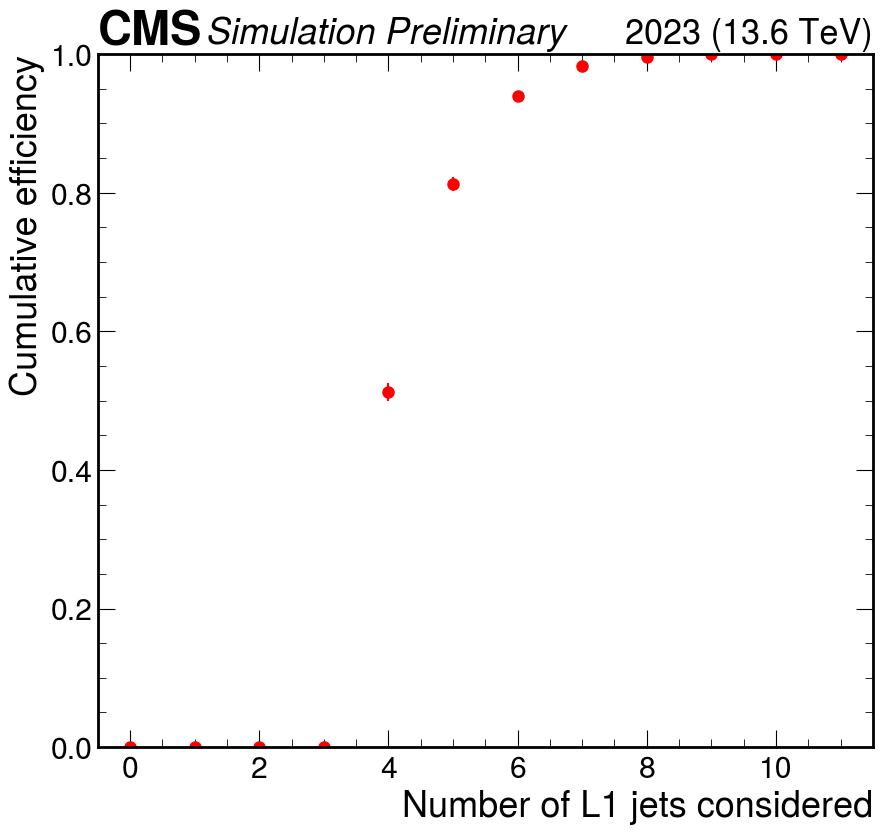

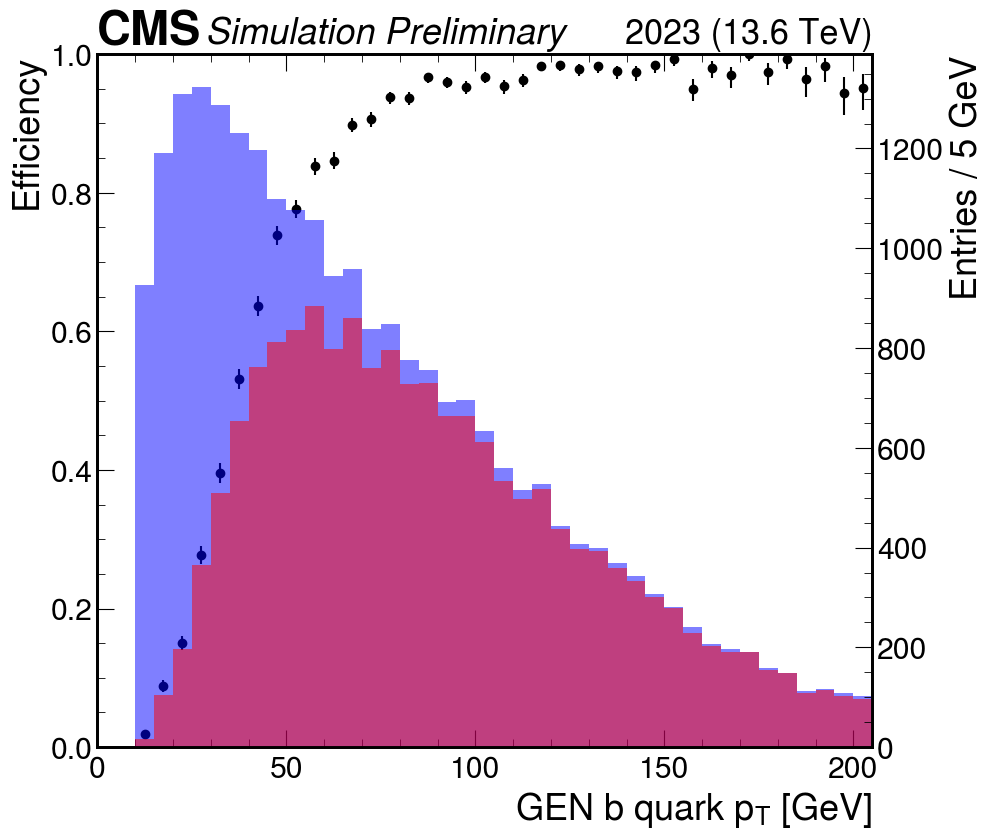

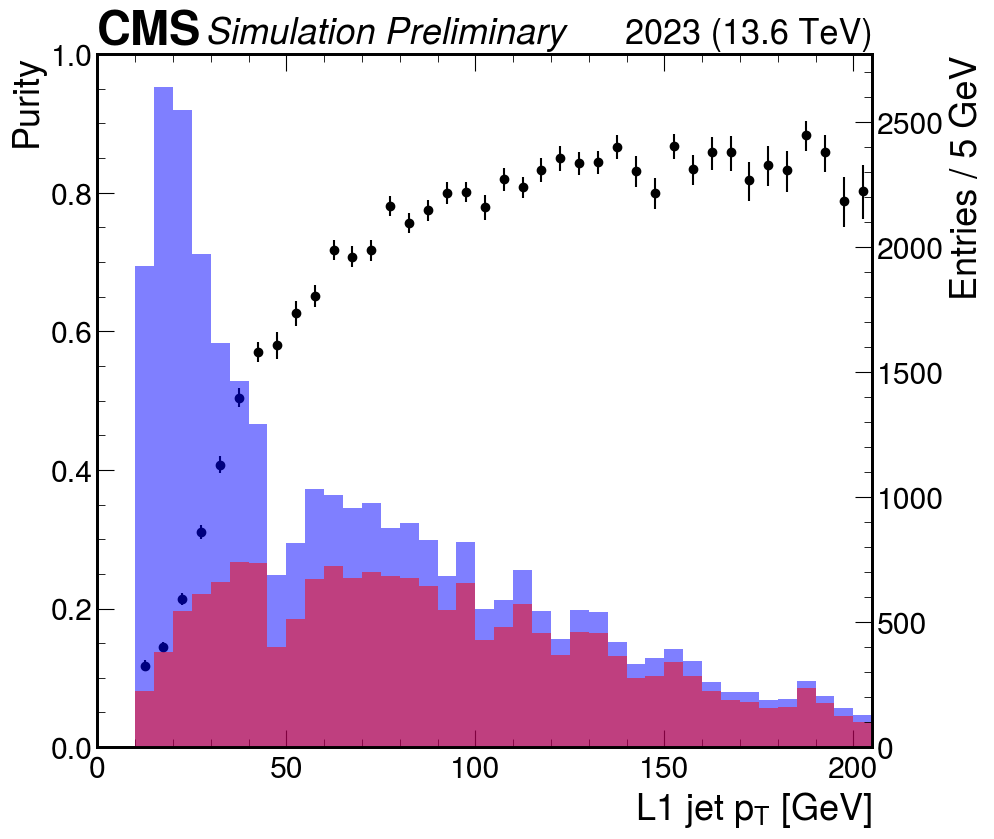

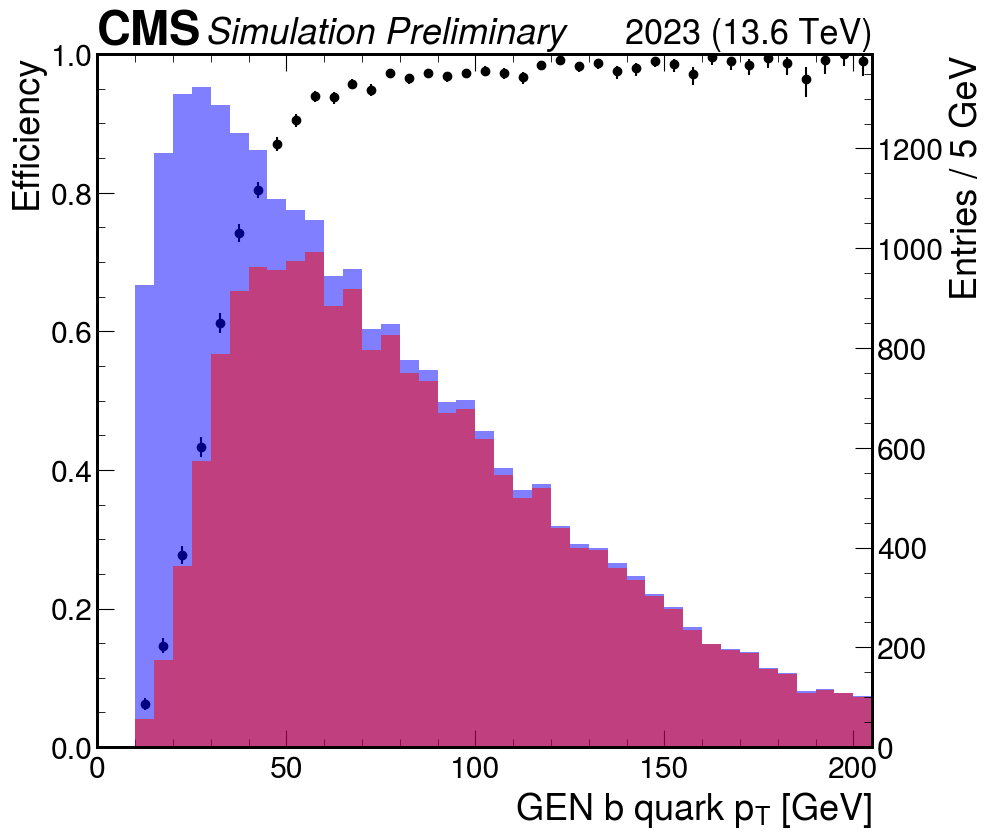

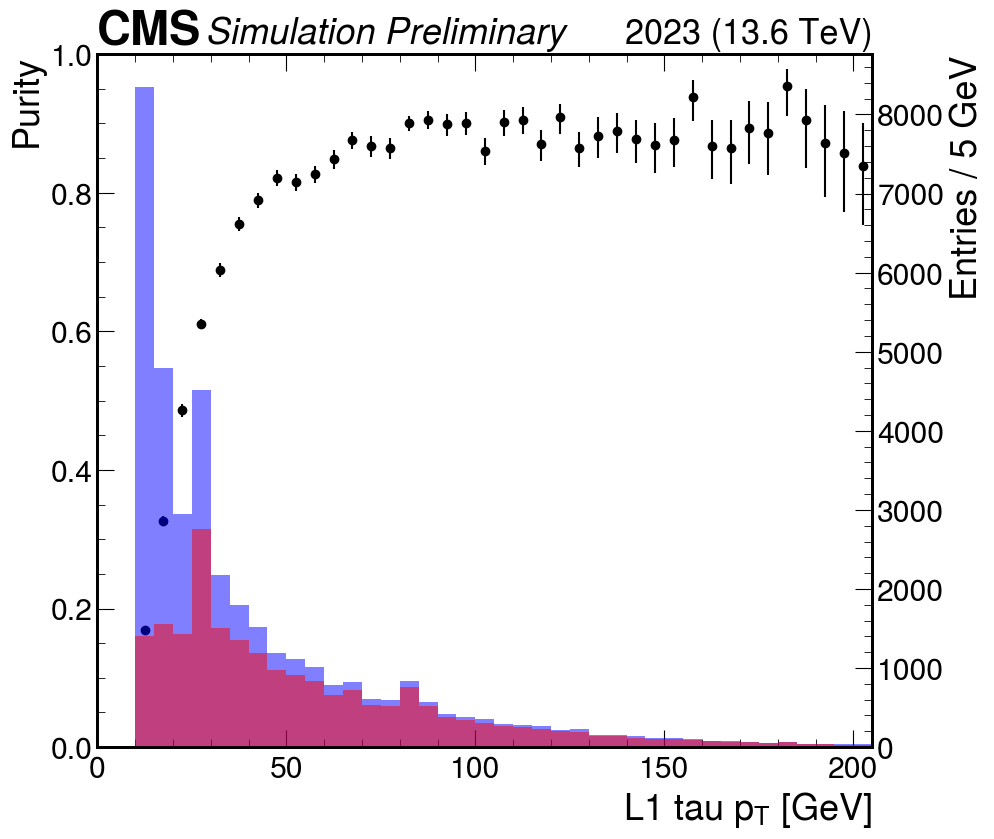

In [85]:
def selections_bbbb(**kwargs):
    
    # Default settings
    nevents = kwargs["nevents"] if "nevents" in kwargs.keys() else 10000
    skip = kwargs["skip"] if "skip" in kwargs.keys() else 0
    verbosity = kwargs["verbosity"] if "verbosity" in kwargs.keys() else 0
    gen_pt_min = kwargs["gen_pt_min"] if "gen_pt_min" in kwargs.keys() else 10.
    gen_eta_max = kwargs["gen_eta_max"] if "gen_eta_max" in kwargs.keys() else 2.5
    off_pt_min = kwargs["off_pt_min"] if "off_pt_min" in kwargs.keys() else 35.
    off_eta_max = kwargs["off_eta_max"] if "off_eta_max" in kwargs.keys() else 2.5
    off_btag_min = kwargs["off_btag_min"] if "off_btag_min" in kwargs.keys() else 0. #@@ DEFAULT IS ZERO ???
    sct_pt_min = kwargs["sct_pt_min"] if "sct_pt_min" in kwargs.keys() else 20.
    sct_eta_max = kwargs["sct_eta_max"] if "sct_eta_max" in kwargs.keys() else 2.5
    use_matched = kwargs["use_matched"] if "use_matched" in kwargs.keys() else False
    #option = kwargs["option"] if "option" in kwargs.keys() else "bbtautau"
  
    events = load_data_bbbb(nevents=nevents,skip=skip,verbosity=verbosity)
    
    if verbosity>=2:
        print()
        print("FULL DEBUG MODE!!!")
        print(" Verbosity: ", verbosity)
        print(" Num evts:  ", len(events["nGenPart"]))
    
    passed_GEN, gen = GEN_acceptance_bbbb(events,pt_min=gen_pt_min,eta_max=gen_eta_max,verbosity=verbosity)
    passed_L1T = L1T_passing_bbbb(events,passed=passed_GEN,verbosity=verbosity)
    matched_L1T = L1T_matching_bbbb(events,gen,passed=passed_L1T,verbosity=verbosity) if use_matched else ak.full_like(passed_L1T,True,dtype=bool)
    passed_HLT = HLT_passing_bbbb(events,passed=matched_L1T,verbosity=verbosity)
    matched_HLT = HLT_matching_bbbb(events,gen,passed=passed_HLT,verbosity=verbosity) if use_matched else ak.full_like(passed_HLT,True,dtype=bool)
    matched_OFF = OFF_matching_bbbb(events,gen,pt_min=off_pt_min,eta_max=off_eta_max,btag_min=off_btag_min,passed=matched_HLT,verbosity=verbosity)
    matched_SCT = SCT_matching_bbbb(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    # Plotting (only plot once)
    if use_matched == False:
        SCT_plot_sig_eff_vs_jet_rank_bbbb(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)
        SCT_plot_eff_vs_jet_pt_bbbb(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)
        SCT_plot_purity_vs_jet_pt_bbbb(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)
        SCT_plot_eff_vs_tau_pt_bbbb(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)
        SCT_plot_purity_vs_tau_pt_bbbb(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    print_summary(
        events,
        passed_GEN=passed_GEN,
        passed_L1T=passed_L1T,
        matched_L1T=matched_L1T,
        passed_HLT=passed_HLT,
        matched_HLT=matched_HLT,
        matched_OFF=matched_OFF,
        matched_SCT=matched_SCT,
        use_matched=use_matched, # Use passed or matched for L1T and HLT
        )

settings = settings_.copy()
settings.update({"off_btag_min":0.})
print(settings)
selections_bbbb(**settings)
settings.update({"use_matched":True})
print(settings)
selections_bbbb(**settings)


## bbtautau (Run 3)

### LOAD

In [86]:
#############################################################################################
#
def load_data_bbtautau(nevents=None,skip=0,verbosity=0):

    # Open ROOT file with uproot
    example_file = "../data/nano_2b2tau_run3.root"
    file = uproot.open(example_file)
    tree = file["Events"]

    if verbosity>=3:
        keys = tree.keys()
        print()
        print("[load_data_bbtautau]")
        print("All branches:")
        for key in keys:
            print(f"  {key}")
        print()
        print("L1 seeds:")
        for key in keys:
            if key.startswith("L1_") : print(f"  {key}")
        print()
        print("HLT paths:")
        for key in keys:
            if key.startswith("HLT_") : print(f"  {key}")

    branches = [
        "event", "run", "luminosityBlock", # Event identification
        "GenPart_pt", "GenPart_eta", "GenPart_phi", # GEN-level kinematics
        "nGenPart","GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_statusFlags", # GEN-level information
        "L1_DoubleIsoTau34er2p1","L1_HTT280er", # L1 seeds
        "HLT_DoubleMediumDeepTauPFTauHPS35_L2NN_eta2p1", "HLT_PFHT280_QuadPFJet30_PNet2BTagMean0p55", # HLT paths
        "nTrigObj", "TrigObj_pt", "TrigObj_eta", "TrigObj_phi", "TrigObj_id", "TrigObj_filterBits", # Trigger objects
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagPNetB", # Offline jets
        "nTau", "Tau_pt", "Tau_eta", "Tau_phi", # Offline taus
        "nL1Jet", "L1Jet_pt", "L1Jet_eta", "L1Jet_phi", # L1 jets 
        "nL1Tau", "L1Tau_pt", "L1Tau_eta", "L1Tau_phi", # L1 taus
    ]

    # Load data into awkward arrays
    events = tree.arrays(branches, library="ak")
    events = events[skip:nevents+skip] if nevents is not None else events[skip:]
    return events

### ACC

In [87]:
#############################################################################################
#
def GEN_acceptance_bbtautau(events,pt_min,eta_max,verbosity=0):

    # Create objects from GEN particle info
    gen = gen_objects(events)

    # Identify taus from Higgs decays
    tau_from_higgs = (gen.id == 15) & (gen.mother_id == 25)

    # Identify indices of taus from Higgs decays
    idx_tau_from_higgs = ak.mask(ak.local_index(tau_from_higgs),tau_from_higgs)

    # Identify daughters of taus
    x,y = ak.unzip(ak.cartesian([idx_tau_from_higgs, gen.mother_idx], nested=True, axis=-1))
    tau_dau = (x == y)
    tau_dau = ak.fill_none(tau_dau,False)
    idx_tau_dau = ak.firsts(ak.argsort(tau_dau,axis=2,ascending=False),axis=2)

    # Identify hadronic tau decays (i.e. daughters are not electrons nor muons)
    had_tau = (abs(gen.id[idx_tau_dau]) != 11) & (abs(gen.id[idx_tau_dau]) != 13)

    # Identify hadronically decaying taus from Higgs decays
    gen["had_tau_from_higgs"] = had_tau & tau_from_higgs 
    #idx_had_tau_from_higgs = ak.mask(ak.local_index(gen.had_tau_from_higgs),gen.had_tau_from_higgs)

    # Identify GEN b-quarks from Higgs decay
    gen["b_quarks_from_higgs"] = (gen.id == 5) & (gen.mother_id == 25)

    # Identify interesting daughters (had taus or b-quarks) from Higgs decay
    gen["daughter"] = gen.had_tau_from_higgs | gen.b_quarks_from_higgs
    daughter_idx = ak.mask(ak.local_index(gen.daughter),gen.daughter)

    # Filter GEN particles to keep only b-quarks from Higgs decay
    gen = gen[gen.daughter]

    # Filter GEN particles to keep only those within acceptance
    gen["in_acc"] = (gen.pt > pt_min) & (abs(gen.eta) < eta_max)
    gen = gen[gen.in_acc]

    # Identify at least 4 GEN particles within acceptance
    num_in_acc = ak.sum(gen.in_acc, axis=-1)
    num_b_quarks = ak.sum(gen.daughter, axis=-1) # Redundant w.r.t. above, but consistent with bbtautau
    passed_GEN = (num_in_acc >= 4) & (num_b_quarks >= 4)
    passed_idx, = ak.where(passed_GEN) # comma dereferences the tupl(ak.array)

    # Identify at least 4 GEN particles within acceptance, two of which are taus and two are b quarks
    num_in_acc = ak.sum(gen.in_acc, axis=-1)
    num_b_quarks = ak.sum(gen.b_quarks_from_higgs, axis=-1)
    num_tau_had = ak.sum(gen.had_tau_from_higgs, axis=-1)
    passed_GEN = (num_in_acc >= 4) & (num_tau_had >= 2) & (num_b_quarks >= 2)
    passed_idx, = ak.where(passed_GEN) # comma dereferences the tupl(ak.array)

    # Only keep events for which all GEN particles are fully in acceptance
    gen = ak.mask(gen,passed_GEN)

    if verbosity>=1:
        print()
        print("[gen_acceptance_bbtautau]")
        print(f"GEN acceptance satisfied for the following events:")
        print(", ".join([f"{x}" for x in passed_idx]))
        print_matching(gen,None)

    return passed_GEN, gen

### L1T

In [88]:
#############################################################################################
#
def L1T_passing_tautau(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    seed = "L1_DoubleIsoTau34er2p1"
    return L1T_passing(events,seed,verbosity=verbosity)

#############################################################################################
#
def L1T_passing_bb(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    seed = "L1_HTT280er"
    return L1T_passing(events,seed,verbosity=verbosity)

#############################################################################################
#
def L1T_passing_bbtautau(events,passed=None,option=None,verbosity=0):
    if option == "tautau":
        return L1T_passing_tautau(events,passed=passed,verbosity=verbosity)
    elif option == "bb":
        return L1T_passing_bb(events,passed=passed,verbosity=verbosity)
    elif option == "bbtautau" or option is None:
        passed_L1T_tautau = L1T_passing_tautau(events,passed=passed,verbosity=verbosity)
        passed_L1T_bb = L1T_passing_bb(events,passed=passed,verbosity=verbosity)
        return passed_L1T_tautau | passed_L1T_bb
    else:
        raise ValueError(f"Invalid option: {option}")

#############################################################################################
#
def L1T_matching_tautau(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    L1Taus = L1Tau_objects(events)
    L1Taus = L1Taus[L1Taus.pt>34.] # Two taus matched to GEN, each satisfying pT > 34 GeV 
    matched_L1T = object_matching(gen,L1Taus,gen_id_filter=15,n=2,verbosity=verbosity)
    return matched_L1T

#############################################################################################
#
def L1T_matching_bb(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    L1Jets = L1Jet_objects(events)
    L1Jets = L1Jets[L1Jets.pt>30.] # Four jets matched to GEN, each contributing 30 GeV to HTT sum
    matched_L1T = object_matching(gen,L1Jets,n=4,verbosity=verbosity)
    return matched_L1T

#############################################################################################
#
def L1T_matching_bbtautau(events,gen,passed=None,option=None,verbosity=0):
    if option == "tautau":
        return L1T_matching_tautau(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bb":
        return L1T_matching_bb(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bbtautau" or option is None:
        matched_L1T_tautau = L1T_matching_tautau(events,gen,passed=passed,verbosity=verbosity)
        matched_L1T_bb = L1T_matching_bb(events,gen,passed=passed,verbosity=verbosity)
        return matched_L1T_tautau | matched_L1T_bb
    else:
        raise ValueError(f"Invalid option: {option}")


### HLT

In [89]:
#############################################################################################
#
def HLT_passing_tautau(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    path = "HLT_DoubleMediumDeepTauPFTauHPS35_L2NN_eta2p1"
    return HLT_passing(events,path,verbosity=verbosity)

#############################################################################################
#
def HLT_passing_bb(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    path = "HLT_PFHT280_QuadPFJet30_PNet2BTagMean0p55"
    return HLT_passing(events,path,verbosity=verbosity)

#############################################################################################
#
def HLT_passing_bbtautau(events,passed=None,option=None,verbosity=0):
    if option == "tautau":
        return HLT_passing_tautau(events,passed=passed,verbosity=verbosity)
    elif option == "bb":
        return HLT_passing_bb(events,passed=passed,verbosity=verbosity)
    elif option == "bbtautau" or option is None:
        passed_HLT_tautau = HLT_passing_tautau(events,passed=passed,verbosity=verbosity)
        passed_HLT_bb = HLT_passing_bb(events,passed=passed,verbosity=verbosity)
        return passed_HLT_tautau | passed_HLT_bb
    else:
        raise ValueError(f"Invalid option: {option}")
    
#############################################################################################
# Filters: https://cmshltinfo.app.cern.ch/path/HLT_DoubleMediumDeepTauPFTauHPS35_L2NN_eta2p1_v
# Trigger bits: https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_1_patch1/PhysicsTools/NanoAOD/python/triggerObjects_cff.py#L137-L166
# Useful bits (two taus): [1,3,5,10] == *Medium*, *DeepTau*, *Hps*, hlt*DoublePFTau*L1HLTMatched
def HLT_matching_tautau(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    trg = HLT_objects(events)

    # DoubleTau trigger matching
    matched_HLT = hlt_matching(
        gen,
        trg,
        passed=passed,
        gen_id_filter=15, # taus only
        hlt_id_filter=15, # taus only
        hlt_bits_filter=[1,3,5,10], # See above
        n=2, # Both taus
        dpt_min=None,dpt_max=None,
        verbosity=verbosity)
    
    return matched_HLT

#############################################################################################
# Filters: https://cmshltinfo.app.cern.ch/path/HLT_PFHT280_QuadPFJet30_PNet2BTagMean0p55_v
# Trigger bits: https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_1_patch1/PhysicsTools/NanoAOD/python/triggerObjects_cff.py#L187-L217
# Useful bits (all four jets): [3,12,28] == hlt4PFCentralJetTightIDPt30, hltPFCentralJetLooseIDQuad30, hlt2PFCentralJetTightIDPt30
# More useful bits (required of just two jets): [26] == hltPFCentralJetPt30PNet2BTagMean0p55 
def HLT_matching_bb(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    trg = HLT_objects(events)

    # All 4 jets
    matched_HLT_4j = hlt_matching(
        gen,
        trg,
        passed=passed,
        gen_id_filter=5, # b quarks only
        hlt_id_filter=1, # Jets
        hlt_bits_filter=[3,12,28], # See above
        n=2, # All four jets
        dpt_min=None,dpt_max=None, # No requirements on delta pT
        verbosity=verbosity)

    # Two b-jets
    matched_HLT_2b = hlt_matching(
        gen,
        trg,
        passed=passed,
        gen_id_filter=5, # b quarks only
        hlt_id_filter=1, # Jets
        hlt_bits_filter=[26], # See above
        n=2, # Just two jets
        dpt_min=None,dpt_max=None, # No requirements on delta pT
        verbosity=verbosity)

    return matched_HLT_4j & matched_HLT_2b

#############################################################################################
#
def HLT_matching_bbtautau(events,gen,passed=None,option=None,verbosity=0):
    if option == "tautau":
        return HLT_matching_tautau(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bb":
        return HLT_matching_bb(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bbtautau" or option is None:
        passed_HLT_tautau = HLT_matching_tautau(events,gen,passed=passed,verbosity=verbosity)
        passed_HLT_bb = HLT_matching_bb(events,gen,passed=passed,verbosity=verbosity)
        return passed_HLT_tautau | passed_HLT_bb
    else:
        raise ValueError(f"Invalid option: {option}")


###  OFF

In [90]:
#############################################################################################
#
def OFF_matching_tautau(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)

    # Extract tau info and filter to keep only those within acceptance
    tau = tau_objects(events)
    tau["in_acc"] = (tau.pt > pt_min) & (abs(tau.eta) < eta_max)
    tau = ak.mask(tau,tau.in_acc)

    # Match reco to gen
    matched_OFF = object_matching(
        gen,
        tau,
        passed=passed,
        gen_id_filter=15,
        n=2,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )
    
    return matched_OFF        

#############################################################################################
#
def OFF_matching_bb(events,gen,pt_min,eta_max,btag_min=0.,passed=None,verbosity=0):

    events = filter_events(events,passed)

    # Extract jet info and filter to keep only those within acceptance
    jet = jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = ak.mask(jet,jet.in_acc)

    matched_OFF_jets = object_matching(
        gen,
        jet, # Only consider jets
        passed=passed,
        gen_id_filter=5,
        n=2,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )
    
    matched_OFF_bjets = object_matching(
        gen,
        jet[jet.btag >= btag_min], #@@ CURRENTLY OFFLINE B-TAGGING NOT APPLIED TO BE CONISTENT WITH L1 SCOUTING CAPABILITIES IN RUN 3
        passed=passed,
        gen_id_filter=5,
        n=2,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )

    
    return matched_OFF_jets #@@ & matched_OFF_bjets

#############################################################################################
#
def OFF_matching_bbtautau(events,gen,pt_min=35.,eta_max=2.5,btag_min=0.,passed=None,verbosity=0):
    matched_OFF_tautau = OFF_matching_tautau(events,gen,pt_min=pt_min,eta_max=eta_max,passed=passed,verbosity=verbosity)
    matched_OFF_bb = OFF_matching_bb(events,gen,pt_min=pt_min,eta_max=eta_max,btag_min=btag_min,passed=passed,verbosity=verbosity)
    return matched_OFF_tautau & matched_OFF_bb


### SCT

In [91]:
#############################################################################################
#
def SCT_matching_tautau(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)
    
    # Extract L1 objects and filter to keep only those within acceptance
    tau = L1Tau_objects(events)
    tau["in_acc"] = (tau.pt > pt_min) & (abs(tau.eta) < eta_max)
    tau = tau[tau.in_acc]

    # Match L1 taus
    matched_SCT = object_matching(
        gen,
        tau,
        passed=passed,
        gen_id_filter=15,
        n=2,
        verbosity=verbosity)

    return matched_SCT

#############################################################################################
#
def SCT_matching_bb(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)
    
    # Extract L1 objects and filter to keep only those within acceptance
    jet = L1Jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    # tau = L1Tau_objects(events)
    # tau["in_acc"] = (tau.pt > pt_min) & (abs(tau.eta) < eta_max)
    # tau = tau[tau.in_acc]

    # L1 jets
    L1_jet_pt = events["L1Jet_pt"]
    L1_jet_eta = events["L1Jet_eta"]
    L1_jet_phi = events["L1Jet_phi"]
    valid_L1_jets = (L1_jet_pt > pt_min) & (abs(L1_jet_eta) < eta_max)
    L1_jet_pt = L1_jet_pt[valid_L1_jets]
    L1_jet_eta = L1_jet_eta[valid_L1_jets]
    L1_jet_phi = L1_jet_phi[valid_L1_jets]
    L1_jets = ak.zip({"pt": L1_jet_pt, "eta": L1_jet_eta, "phi": L1_jet_phi, "id": ak.full_like(L1_jet_pt,1)})

    # Match L1 jets 
    matched_SCT = object_matching(
        gen,
        L1_jets,
        passed=passed,
        gen_id_filter=5,
        n=2,
        verbosity=verbosity)

    return matched_SCT

#############################################################################################
#
def SCT_matching_bbtautau(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    matched_SCT_tautau = SCT_matching_tautau(events,gen,pt_min=pt_min,eta_max=eta_max,passed=passed,verbosity=verbosity)
    matched_SCT_bb = SCT_matching_bb(events,gen,pt_min=pt_min,eta_max=eta_max,passed=passed,verbosity=verbosity)
    return matched_SCT_tautau & matched_SCT_bb

### PLOT

In [92]:
#############################################################################################
#
def SCT_plot_eff_vs_tau_pt_bbtautau(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":2023, "com":13.6, "nbins":41, "start":0., "stop":205., "xlabel":"GEN tau lepton p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "eff",events,"L1Tau",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=15,
        n=2,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)

#############################################################################################
#
def SCT_plot_purity_vs_tau_pt_bbtautau(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":2023, "com":13.6, "nbins":41, "start":0., "stop":205., "xlabel":"L1 tau p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "purity",events,"L1Tau",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=15,
        n=2,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)

### EXECUTE


{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.0, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'tautau', 'use_matched': False}


/var/folders/yl/5vt7h81d1839m08yqxwjt93w0000gn/T/ipykernel_11889/3967608461.py:7: RuntimeWarning: invalid value encountered in true_divide
  efficiency = numer / denom



              Events    Eff   Gain
STANDARD (No matching @ L1 & HLT)
Inclusive      10000 
Acceptance      7639   0.76   0.21
L1T             4703   0.47   0.35
HLT              950   0.10   1.72
Offline          317   0.03   5.16
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      7639   0.76
Scouting        1636   0.16
{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.0, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'tautau', 'use_matched': True}

              Events    Eff   Gain
STANDARD (W/ matching @ L1 & HLT)
Inclusive      10000 
Acceptance      7639   0.76   0.21
L1T             1280   0.13   1.28
HLT              669   0.07   2.45
Offline          281   0.03   5.82
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      7639   0.76
Scouting        1636   0.16

{'debug': False, 'nevents': 10000, 'skip': 0, 've

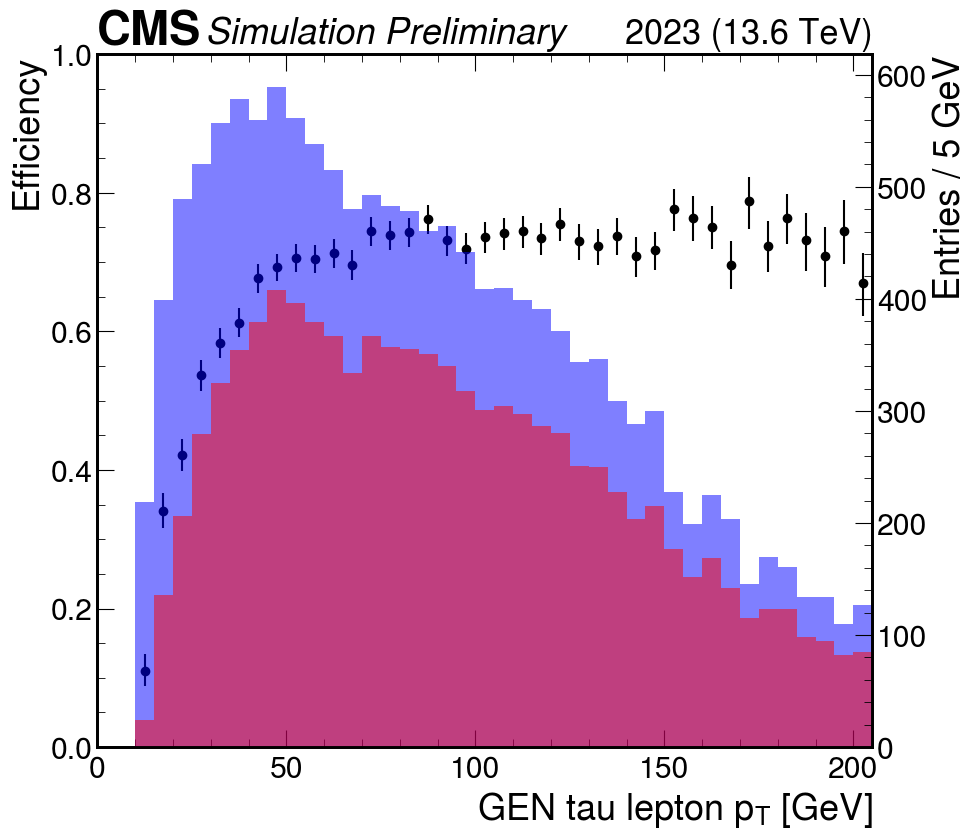

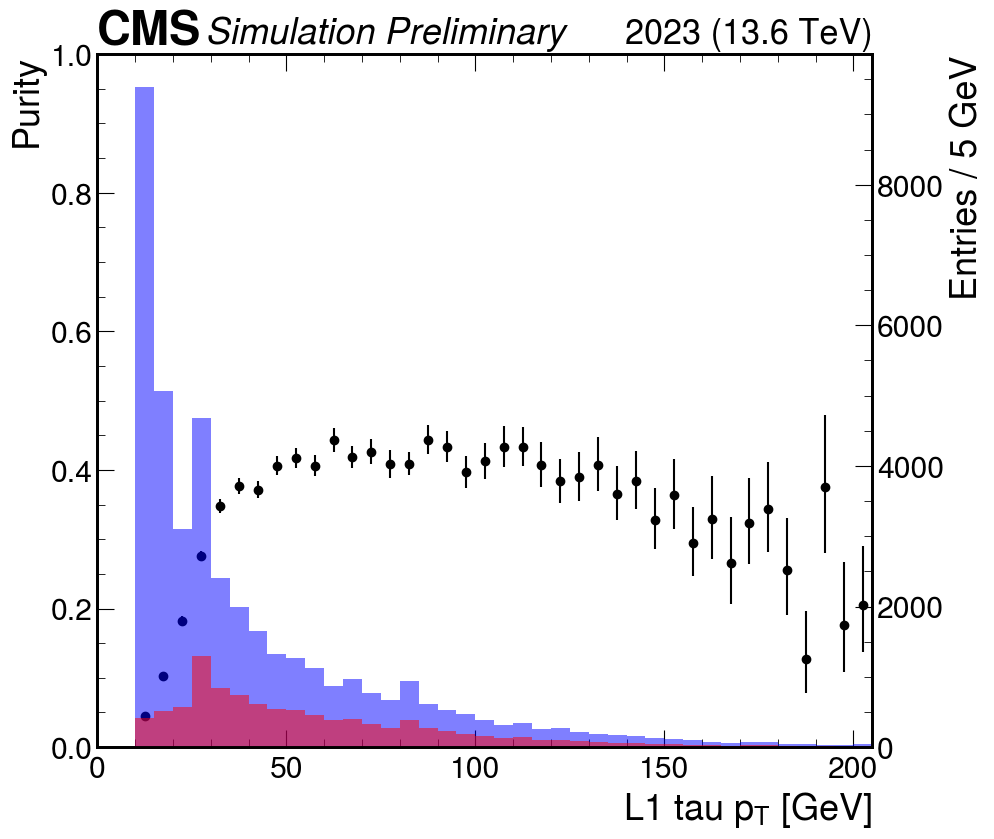

In [93]:
def selections_bbtautau(**kwargs):

    # Default settings
    nevents = kwargs["nevents"] if "nevents" in kwargs.keys() else 10000
    skip = kwargs["skip"] if "skip" in kwargs.keys() else 0
    verbosity = kwargs["verbosity"] if "verbosity" in kwargs.keys() else 0
    gen_pt_min = kwargs["gen_pt_min"] if "gen_pt_min" in kwargs.keys() else 10.
    gen_eta_max = kwargs["gen_eta_max"] if "gen_eta_max" in kwargs.keys() else 2.5
    off_pt_min = kwargs["off_pt_min"] if "off_pt_min" in kwargs.keys() else 35.
    off_eta_max = kwargs["off_eta_max"] if "off_eta_max" in kwargs.keys() else 2.5
    off_btag_min = kwargs["off_btag_min"] if "off_btag_min" in kwargs.keys() else 0. #@@ DEFAULT IS ZERO ???
    sct_pt_min = kwargs["sct_pt_min"] if "sct_pt_min" in kwargs.keys() else 20.
    sct_eta_max = kwargs["sct_eta_max"] if "sct_eta_max" in kwargs.keys() else 2.5
    use_matched = kwargs["use_matched"] if "use_matched" in kwargs.keys() else False
    option = kwargs["option"] if "option" in kwargs.keys() else "bbtautau"

    events = load_data_bbtautau(nevents=nevents,skip=skip,verbosity=verbosity)

    if verbosity>=2:
        print()
        print("FULL DEBUG MODE!!!")
        print(" Verbosity: ", verbosity)
        print(" Num evts:  ", len(events["nGenPart"]))

    passed_GEN, gen = GEN_acceptance_bbtautau(events,pt_min=gen_pt_min,eta_max=gen_eta_max,verbosity=verbosity)
    passed_L1T = L1T_passing_bbtautau(events,passed=passed_GEN,option=option,verbosity=verbosity)
    matched_L1T = L1T_matching_bbtautau(events,gen,passed=passed_L1T,option=option,verbosity=verbosity) if use_matched else ak.full_like(passed_L1T,True,dtype=bool)
    passed_HLT = HLT_passing_bbtautau(events,passed=matched_L1T,option=option,verbosity=verbosity)
    matched_HLT = HLT_matching_bbtautau(events,gen,passed=passed_HLT,option=option,verbosity=verbosity) if use_matched else ak.full_like(passed_HLT,True,dtype=bool)
    matched_OFF = OFF_matching_bbtautau(events,gen,pt_min=off_pt_min,eta_max=off_eta_max,btag_min=off_btag_min,passed=matched_HLT,verbosity=verbosity)
    matched_SCT = SCT_matching_bbtautau(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    # Plotting (only plot once)
    if use_matched == False and option == "tautau":
        SCT_plot_eff_vs_tau_pt_bbtautau(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)
        SCT_plot_purity_vs_tau_pt_bbtautau(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    print_summary(
        events,
        passed_GEN=passed_GEN,
        passed_L1T=passed_L1T,
        matched_L1T=matched_L1T,
        passed_HLT=passed_HLT,
        matched_HLT=matched_HLT,
        matched_OFF=matched_OFF,
        matched_SCT=matched_SCT,
        use_matched=use_matched, # Use passed or matched for L1T and HLT
        )

# option="tautau"
print()
settings = settings_.copy()
settings.update({"off_btag_min":0.})
settings.update({"option":"tautau"})
print(settings)
selections_bbtautau(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbtautau(**settings) 

# option="bb"
print()
settings = settings_.copy()
settings.update({"off_btag_min":0.})
settings.update({"option":"bb"})
print(settings)
selections_bbtautau(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbtautau(**settings) 

# option="bbtautau"
print()
settings = settings_.copy()
settings.update({"off_btag_min":0.})
settings.update({"option":"bbtautau"})
print(settings)
selections_bbtautau(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbtautau(**settings) 


## bbbb (Phase 2)

### LOAD

In [94]:
#############################################################################################
# 
def load_data_bbbb_phase2(nevents=None,skip=0,verbosity=0):

    # Open ROOT file with uproot
    example_file = "../data/nano_4b_phase2.root"
    file = uproot.open(example_file)
    tree = file["Events"]

    if verbosity>=3:
        keys = tree.keys()
        print()
        print("[load_data_bbbb_phase2]")
        print("All branches:")
        for key in keys:
            print(f"  {key}")
        print()
        print("L1 seeds:")
        for key in keys:
            if key.startswith("L1T_") : print(f"  {key}")
        print()
        print("HLT paths:")
        for key in keys:
            if key.startswith("HLT_") : print(f"  {key}")

    branches = [
        "GenPart_pt", "GenPart_eta", "GenPart_phi", # GEN-level kinematics
        "nGenPart", "GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_statusFlags", # GEN-level information
        "L1T_PFHT400PT30_QuadPFPuppiJet_70_55_40_40_2p4", # L1 seeds
        "HLT_PFHT200PT30_QuadPFPuppiJet_70_40_30_30_TriplePFPuppiBTagDeepFlavour_2p4", # HLT paths
        "HLT_PFHT330PT30_QuadPFPuppiJet_75_60_45_40_TriplePFPuppiBTagDeepFlavour_2p4", # HLT paths
        "nTrigObj", "TrigObj_pt", "TrigObj_eta", "TrigObj_phi", "TrigObj_id", "TrigObj_filterBits", # Trigger objects
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagPNetB", "Jet_btagDeepFlavB", # Offline jets
        "nL1Jet", "L1Jet_pt", "L1Jet_eta", "L1Jet_phi", # L1 jets 
        "nL1DisplacedJet", "L1DisplacedJet_pt", "L1DisplacedJet_eta", "L1DisplacedJet_phi", "L1DisplacedJet_btagScore", # L1 displaced jets 
    ]

    # Load data into awkward arrays
    events = tree.arrays(branches, library="ak")
    events = events[skip:nevents+skip] if nevents is not None else events[skip:]
    return events


### ACC

In [95]:
#############################################################################################
#
def GEN_acceptance_bbbb_phase2(events,pt_min,eta_max,verbosity=0):
    return GEN_acceptance_bbbb(events,pt_min=pt_min,eta_max=eta_max,verbosity=verbosity)

### L1T

In [96]:
#############################################################################################
#
def L1T_passing_bbbb_phase2(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    seed = "L1T_PFHT400PT30_QuadPFPuppiJet_70_55_40_40_2p4"
    return L1T_passing(events,seed,verbosity=verbosity)

#############################################################################################
#
def L1T_matching_bbbb_phase2(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    L1Jets = L1Jet_objects(events)
    matched_L1T = object_matching(gen,L1Jets,passed=passed,gen_id_filter=5,n=4,verbosity=verbosity)
    return matched_L1T

### HLT

In [97]:
#############################################################################################
#
def HLT_passing_bbbb_phase2(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    path = "HLT_PFHT200PT30_QuadPFPuppiJet_70_40_30_30_TriplePFPuppiBTagDeepFlavour_2p4" # Looser
    #path = "HLT_PFHT330PT30_QuadPFPuppiJet_75_60_45_40_TriplePFPuppiBTagDeepFlavour_2p4" # Tighter
    return HLT_passing(events,path,verbosity=verbosity)

#############################################################################################
# Trigger bits: https://github.com/ic-l1ds/cmssw/blob/14_2_0_pre1_trigobj_ph2/PhysicsTools/NanoAOD/python/triggerObjects_cff.py#L190-L193
# Useful bits (all four jets): [1,2,3] == hltPFPuppiCentralJetsQuad*HT*MaxEta2p4, hlt*PFPuppiCentralJet*MaxEta2p4, hltPFPuppiCentralJetQuad*MaxEta2p4
# More useful bits (required of just two jets): [0] == hltBTagPFPuppiDeepFlavour*Eta2p4TripleEta2p4 
def HLT_matching_bbbb_phase2(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    trg = HLT_objects(events)

    # DoubleTau trigger matching
    matched_HLT = hlt_matching(
        gen,
        trg,
        passed=passed,
        gen_id_filter=5, # Only b quarks
        hlt_id_filter=1, # Only jets
        hlt_bits_filter=[0,2,3], #@@ These seeem to be the most useful bits, bit=1 rarely set ...??
        n=4,
        dpt_min=None,dpt_max=None, # No requirements on delta pT
        verbosity=verbosity)
    
    return matched_HLT

### OFF

In [98]:
#############################################################################################
#
def OFF_matching_bbbb_phase2(events,gen,pt_min,eta_max,btag_min=0.,passed=None,verbosity=0):
    events = filter_events(events,passed)

    # Extract jet info and filter to keep only those within acceptance
    jet = jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    matched_OFF_jets = object_matching(
        gen,
        jet,
        passed=passed,
        gen_id_filter=5,
        n=4,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )
    
    matched_OFF_bjets = object_matching(
        gen,
        jet[jet.btag >= btag_min], # Subset of jets that satisfy b-tagging requirement
        passed=passed,
        gen_id_filter=5,
        n=4, # Require 4 b-tagged jets
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )

    #@@ WHAT B-TAGGING REQ SHOULD WE APPLY HERE????

    return matched_OFF_jets# & matched_OFF_bjets

### SCT

In [99]:
#############################################################################################
#
def SCT_matching_bbbb_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)
    
    # Extract L1 jets and filter to keep only those within acceptance
    jet = L1Jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    # Extract L1 displaced jets and filter to keep only those within acceptance
    djet = L1DJet_objects(events)
    djet["btag"] = events["L1DisplacedJet_btagScore"]
    djet["in_acc"] = (djet.pt > pt_min) & (abs(djet.eta) < eta_max)
    djet = djet[djet.in_acc]

    # Concatenate L1 jets and L1 displaced jets
    #@@ jet = ak.concatenate([jet,djet],axis=-1) #@@ NEED TO REMOVE OVERLAPPING JETS

    matched_SCT_jets = object_matching(
        gen,
        jet,
        passed=passed,
        gen_id_filter=5,
        n=4,
        verbosity=verbosity)

    matched_SCT_bjets = object_matching(
        gen,
        djet[djet.btag > 0.55], # Subset of jets that satisfy b-tagging requirement
        passed=passed,
        gen_id_filter=5,
        n=4, # Require 4 b-tagged jets
        verbosity=verbosity)

    #@@ WHAT B-TAGGING REQ SHOULD WE APPLY HERE????

    return matched_SCT_jets# & matched_SCT_bjets


### PLOT

In [100]:
#############################################################################################
#
def SCT_plot_sig_eff_vs_jet_rank_bbbb_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    plot_sig_eff_vs_jet_rank(events,"L1DisplacedJet",gen,pt_min,eta_max,passed=passed,verbosity=verbosity,year="Phase 2",com=14)

#############################################################################################
#
def SCT_plot_eff_vs_jet_pt_bbbb_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":"Phase 2", "com":14, "nbins":41, "start":0., "stop":205., "xlabel":"GEN b quark p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "eff",events,"L1Jet",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=5,
        n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)

#############################################################################################
#
def SCT_plot_purity_vs_jet_pt_bbbb_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":"Phase 2", "com":14, "nbins":41, "start":0., "stop":205., "xlabel":"L1 jet p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "purity",events,"L1Jet",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=5,
        n=4,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)


### EXECUTE

{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.55, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'bbtautau', 'use_matched': False}


/var/folders/yl/5vt7h81d1839m08yqxwjt93w0000gn/T/ipykernel_11889/3967608461.py:7: RuntimeWarning: invalid value encountered in true_divide
  efficiency = numer / denom



              Events    Eff   Gain
STANDARD (No matching @ L1 & HLT)
Inclusive      10000 
Acceptance      6559   0.66   0.67
L1T             3566   0.36   1.24
HLT             2479   0.25   1.78
Offline          809   0.08   5.45
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      6559   0.66
Scouting        4406   0.44
{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.55, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'bbtautau', 'use_matched': True}

              Events    Eff   Gain
STANDARD (W/ matching @ L1 & HLT)
Inclusive      10000 
Acceptance      6559   0.66   0.67
L1T             2505   0.25   1.76
HLT              773   0.08   5.70
Offline          490   0.05   8.99
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      6559   0.66
Scouting        4406   0.44


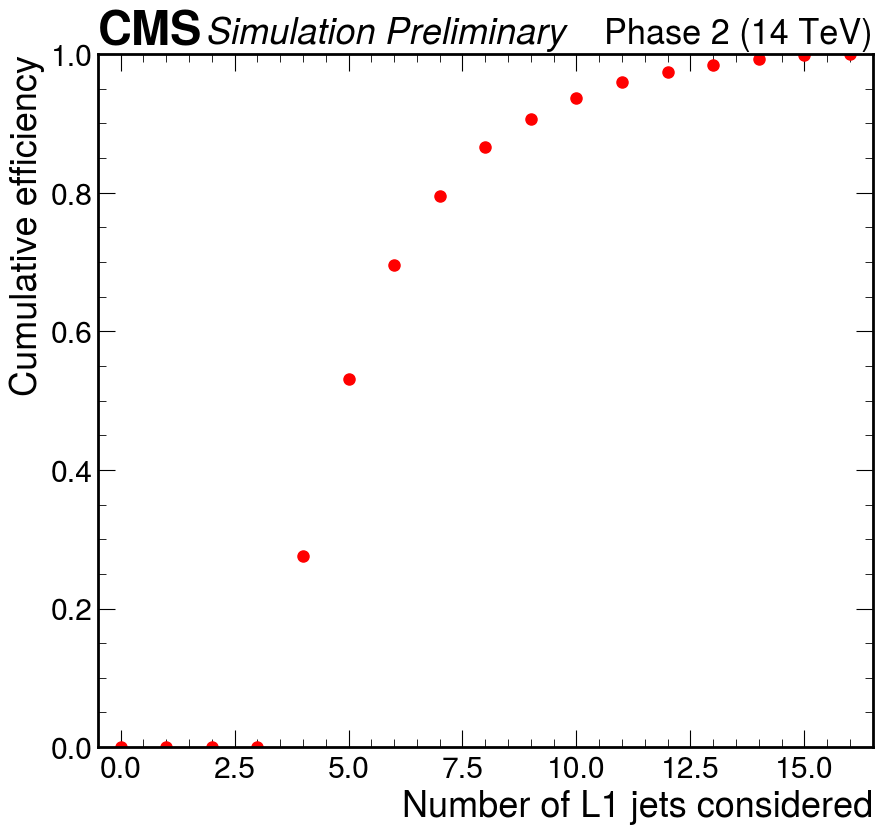

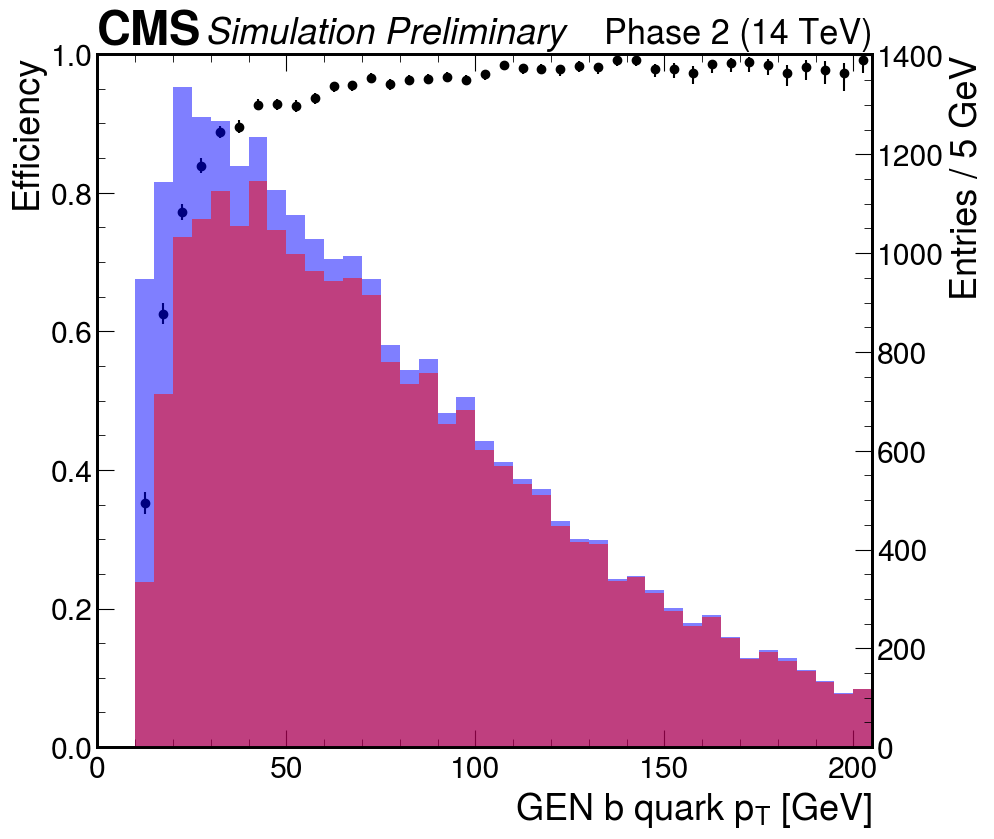

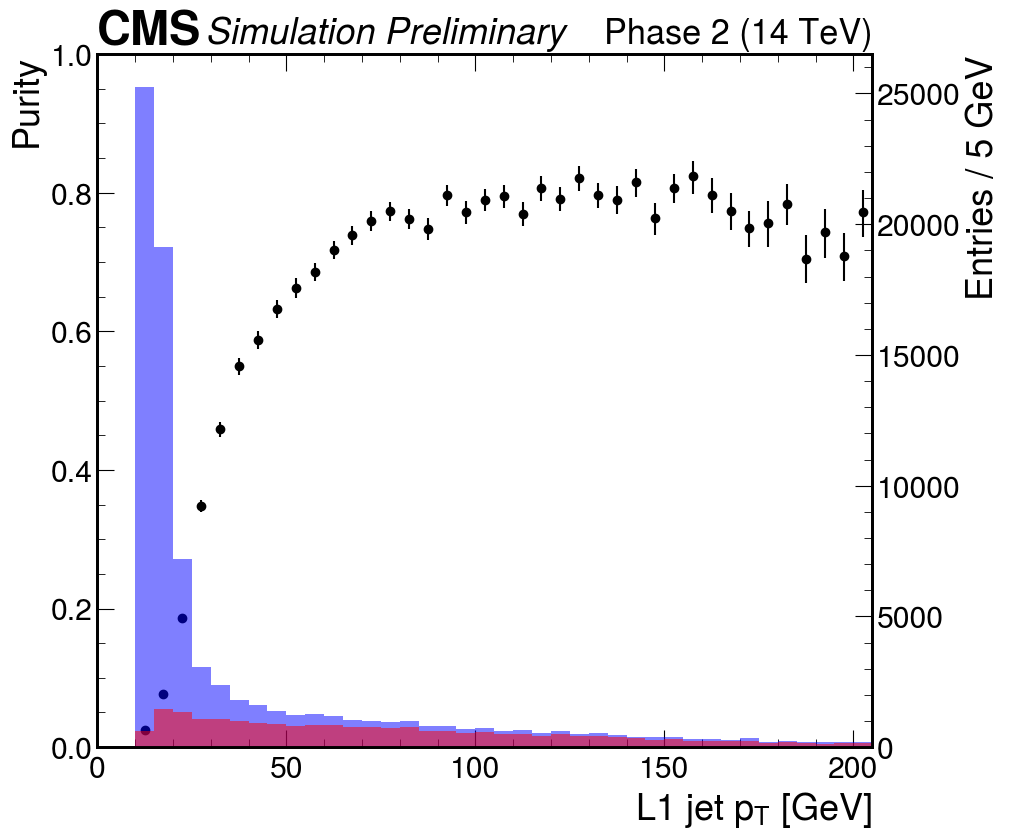

In [101]:
def selections_bbbb_phase2(**kwargs):

    # Default settings
    nevents = kwargs["nevents"] if "nevents" in kwargs.keys() else 10000
    skip = kwargs["skip"] if "skip" in kwargs.keys() else 0
    verbosity = kwargs["verbosity"] if "verbosity" in kwargs.keys() else 0
    gen_pt_min = kwargs["gen_pt_min"] if "gen_pt_min" in kwargs.keys() else 10.
    gen_eta_max = kwargs["gen_eta_max"] if "gen_eta_max" in kwargs.keys() else 2.5
    off_pt_min = kwargs["off_pt_min"] if "off_pt_min" in kwargs.keys() else 35.
    off_eta_max = kwargs["off_eta_max"] if "off_eta_max" in kwargs.keys() else 2.5
    off_btag_min = kwargs["off_btag_min"] if "off_btag_min" in kwargs.keys() else 0. #@@ DEFAULT IS ZERO ???
    sct_pt_min = kwargs["sct_pt_min"] if "sct_pt_min" in kwargs.keys() else 20.
    sct_eta_max = kwargs["sct_eta_max"] if "sct_eta_max" in kwargs.keys() else 2.5
    use_matched = kwargs["use_matched"] if "use_matched" in kwargs.keys() else False
    #option = kwargs["option"] if "option" in kwargs.keys() else "bbtautau"

    events = load_data_bbbb_phase2(nevents=nevents,skip=skip,verbosity=verbosity)

    if verbosity>=2:
        print()
        print("FULL DEBUG MODE!!!")
        print(" Verbosity: ", verbosity)
        print(" Num evts:  ", len(events["nGenPart"]))
    
    passed_GEN, gen = GEN_acceptance_bbbb_phase2(events,pt_min=gen_pt_min,eta_max=gen_eta_max,verbosity=verbosity)
    passed_L1T = L1T_passing_bbbb_phase2(events,passed=passed_GEN,verbosity=verbosity)
    matched_L1T = L1T_matching_bbbb_phase2(events,gen,passed=passed_L1T,verbosity=verbosity) if use_matched else ak.full_like(passed_L1T,True,dtype=bool)
    passed_HLT = HLT_passing_bbbb_phase2(events,passed=matched_L1T,verbosity=verbosity)
    matched_HLT = HLT_matching_bbbb_phase2(events,gen,passed=passed_HLT,verbosity=verbosity) if use_matched else ak.full_like(passed_HLT,True,dtype=bool)
    matched_OFF = OFF_matching_bbbb_phase2(events,gen,pt_min=off_pt_min,eta_max=off_eta_max,btag_min=off_btag_min,passed=matched_HLT,verbosity=verbosity)
    matched_SCT = SCT_matching_bbbb_phase2(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    # Plotting (only plot once)
    if use_matched == False:
        SCT_plot_sig_eff_vs_jet_rank_bbbb_phase2(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)
        SCT_plot_eff_vs_jet_pt_bbbb_phase2(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)
        SCT_plot_purity_vs_jet_pt_bbbb_phase2(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    print_summary(
        events,
        passed_GEN=passed_GEN,
        passed_L1T=passed_L1T,
        matched_L1T=matched_L1T,
        passed_HLT=passed_HLT,
        matched_HLT=matched_HLT,
        matched_OFF=matched_OFF,
        matched_SCT=matched_SCT,
        use_matched=use_matched, # Use passed or matched for L1T and HLT
        )

settings = settings_.copy()
print(settings)
selections_bbbb_phase2(**settings)
settings.update({"use_matched":True})
print(settings)
selections_bbbb_phase2(**settings)

## bbtautau (Phase 2)

### LOAD

In [102]:
#############################################################################################
# 
def load_data_bbtautau_phase2(nevents=None,skip=0,verbosity=0):

    # Open ROOT file with uproot
    example_file = "../data/nano_2b2tau_phase2.root"
    file = uproot.open(example_file)
    tree = file["Events"]

    if verbosity>=3:
        keys = tree.keys()
        print()
        print("[load_data_bbtautau_phase2]")
        print("All branches:")
        for key in keys:
            print(f"  {key}")
        print()
        print("L1 seeds:")
        for key in keys:
            if key.startswith("L1T_") : print(f"  {key}")
        print()
        print("HLT paths:")
        for key in keys:
            if key.startswith("HLT_") : print(f"  {key}")

    branches = [
        "GenPart_pt", "GenPart_eta", "GenPart_phi", # GEN-level kinematics
        "nGenPart", "GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_statusFlags", # GEN-level information
        "L1_pDoublePuppiTau52_52_final", #@@ L1 seeds
        "L1T_PFHT400PT30_QuadPFPuppiJet_70_55_40_40_2p4", # L1 seeds
        "HLT_DoubleMediumDeepTauPFTauHPS35_eta2p1", # HLT paths
        "HLT_PFHT200PT30_QuadPFPuppiJet_70_40_30_30_TriplePFPuppiBTagDeepFlavour_2p4", # HLT paths
        "HLT_PFHT330PT30_QuadPFPuppiJet_75_60_45_40_TriplePFPuppiBTagDeepFlavour_2p4", # HLT paths
        "nTrigObj", "TrigObj_pt", "TrigObj_eta", "TrigObj_phi", "TrigObj_id", "TrigObj_filterBits", # Trigger objects
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagPNetB", # Offline jets
        "nTau", "Tau_pt", "Tau_eta", "Tau_phi", # Offline taus
        "nL1Jet", "L1Jet_pt", "L1Jet_eta", "L1Jet_phi", # L1 displaced jets 
        "nL1DisplacedJet", "L1DisplacedJet_pt", "L1DisplacedJet_eta", "L1DisplacedJet_phi", "L1DisplacedJet_btagScore", # L1 displaced jets 
        "nL1GTnnTau", "L1GTnnTau_pt", "L1GTnnTau_eta", "L1GTnnTau_phi", # L1 taus 
    ]

    # Load data into awkward arrays
    events = tree.arrays(branches, library="ak")
    events = events[skip:nevents+skip] if nevents is not None else events[skip:]
    return events

### ACC

In [103]:
#############################################################################################
#
def GEN_acceptance_bbtautau_phase2(events,pt_min,eta_max,verbosity=0):
    return GEN_acceptance_bbtautau(events,pt_min=pt_min,eta_max=eta_max,verbosity=verbosity)

### L1T

In [104]:
#############################################################################################
#
def L1T_passing_tautau_phase2(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    seed = "L1_pDoublePuppiTau52_52_final"
    return L1T_passing(events,seed,verbosity=verbosity)

#############################################################################################
#
def L1T_passing_bb_phase2(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    seed = "L1T_PFHT400PT30_QuadPFPuppiJet_70_55_40_40_2p4"
    return L1T_passing(events,seed,verbosity=verbosity)

#############################################################################################
#
def L1T_passing_bbtautau_phase2(events,passed=None,option=None,verbosity=0):
    if option == "tautau":
        return L1T_passing_tautau_phase2(events,passed=passed,verbosity=verbosity)
    elif option == "bb":
        return L1T_passing_bb_phase2(events,passed=passed,verbosity=verbosity)
    elif option == "bbtautau" or option is None:
        passed_L1T_tautau = L1T_passing_tautau_phase2(events,passed=passed,verbosity=verbosity)
        passed_L1T_bb = L1T_passing_bb_phase2(events,passed=passed,verbosity=verbosity)
        return passed_L1T_tautau | passed_L1T_bb
    else:
        raise ValueError(f"Invalid option: {option}")

#############################################################################################
#
def L1T_matching_tautau_phase2(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    L1Taus = L1TauP2_objects(events)
    L1Taus = L1Taus[L1Taus.pt>52.] # Two taus matched to GEN, each satisfying pT > 52 GeV 
    matched_L1T = object_matching(gen,L1Taus,passed=passed,gen_id_filter=15,n=2,verbosity=verbosity)
    return matched_L1T

#############################################################################################
#
def L1T_matching_bb_phase2(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    L1Jets = L1Jet_objects(events)
    L1Jets = L1Jets[L1Jets.pt>30.] # Four jets matched to GEN, each contributing 30 GeV to HTT sum (conservative, thresholds are actually higher)
    matched_L1T = object_matching(gen,L1Jets,passed=passed,n=4,verbosity=verbosity)
    return matched_L1T

#############################################################################################
#
def L1T_matching_bbtautau_phase2(events,gen,passed=None,option=None,verbosity=0):
    if option == "tautau":
        return L1T_matching_tautau_phase2(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bb":
        return L1T_matching_bb_phase2(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bbtautau" or option is None:
        matched_L1T_tautau = L1T_matching_tautau_phase2(events,gen,passed=passed,verbosity=verbosity)
        matched_L1T_bb = L1T_matching_bb_phase2(events,gen,passed=passed,verbosity=verbosity)
        return matched_L1T_tautau | matched_L1T_bb 
    else:
        raise ValueError(f"Invalid option: {option}")


### HLT

In [105]:
#############################################################################################
#
def HLT_passing_tautau_phase2(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    path = "HLT_DoubleMediumDeepTauPFTauHPS35_eta2p1"
    return HLT_passing(events,path,verbosity=verbosity)

#############################################################################################
#
def HLT_passing_bb_phase2(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    path = "HLT_PFHT200PT30_QuadPFPuppiJet_70_40_30_30_TriplePFPuppiBTagDeepFlavour_2p4" # Looser
    #path = "HLT_PFHT330PT30_QuadPFPuppiJet_75_60_45_40_TriplePFPuppiBTagDeepFlavour_2p4" # Tighter
    return HLT_passing(events,path,verbosity=verbosity)

#############################################################################################
#
def HLT_passing_bbtautau_phase2(events,passed=None,option=None,verbosity=0):
    if option == "tautau":
        return HLT_passing_tautau_phase2(events,passed=passed,verbosity=verbosity)    
    elif option == "bb":
        return HLT_passing_bb_phase2(events,passed=passed,verbosity=verbosity)
    elif option == "bbtautau" or option is None:
        passed_HLT_tautau = HLT_passing_tautau_phase2(events,passed=passed,verbosity=verbosity)
        passed_HLT_bb = HLT_passing_bb_phase2(events,passed=passed,verbosity=verbosity)
        return passed_HLT_tautau | passed_HLT_bb
    else:
        raise ValueError(f"Invalid option: {option}")

#############################################################################################
# Trigger bits: https://github.com/ic-l1ds/cmssw/blob/14_2_0_pre1_trigobj_ph2/PhysicsTools/NanoAOD/python/triggerObjects_cff.py#L139-L169
# Useful bits (two taus): [0,1,2,3] == *Medium*, *DeepTau*, *Hps*, hlt*DoublePFTau*, *Hps*
def HLT_matching_tautau_phase2(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    trg = HLT_objects(events)

    # DoubleTau trigger matching
    matched_HLT = hlt_matching(
        gen,
        trg,
        passed=passed,
        gen_id_filter=15, # taus only
        hlt_id_filter=15, # taus only
        hlt_bits_filter=[0,1,2,3], # See above
        n=2, # Both taus
        dpt_min=None,dpt_max=None,
        verbosity=verbosity)
    
    return matched_HLT

#############################################################################################
# Trigger bits: https://github.com/ic-l1ds/cmssw/blob/14_2_0_pre1_trigobj_ph2/PhysicsTools/NanoAOD/python/triggerObjects_cff.py#L190-L193
# Useful bits (all four jets): [1,2,3] == hltPFPuppiCentralJetsQuad*HT*MaxEta2p4, hlt*PFPuppiCentralJet*MaxEta2p4, hltPFPuppiCentralJetQuad*MaxEta2p4
# More useful bits (required of just two jets): [0] == hltBTagPFPuppiDeepFlavour*Eta2p4TripleEta2p4 
def HLT_matching_bb_phase2(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    trg = HLT_objects(events)

    # DoubleTau trigger matching
    matched_HLT = hlt_matching(
        gen,
        trg,
        passed=passed,
        gen_id_filter=5, # Only b quarks
        hlt_id_filter=1, # Only jets
        hlt_bits_filter=[0,2,3], #@@ These seeem to be the most useful bits, bit=1 rarely set ...??
        n=4,
        dpt_min=None,dpt_max=None, # No requirements on delta pT
        verbosity=verbosity)
    
    return matched_HLT

#############################################################################################
#
def HLT_matching_bbtautau_phase2(events,gen,passed=None,option=None,verbosity=0):
    if option == "tautau":
        return HLT_matching_tautau_phase2(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bb":
        return HLT_matching_bb_phase2(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bbtautau" or option is None:
        passed_HLT_tautau = HLT_matching_tautau_phase2(events,gen,passed=passed,verbosity=verbosity)
        passed_HLT_bb = HLT_matching_bb_phase2(events,gen,passed=passed,verbosity=verbosity)
        return passed_HLT_tautau | passed_HLT_bb
    else:
        raise ValueError(f"Invalid option: {option}")


### OFF

In [106]:
#############################################################################################
#
def OFF_matching_tautau_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)

    # Extract tau info and filter to keep only those within acceptance
    tau = tau_objects(events)
    tau["in_acc"] = (tau.pt > pt_min) & (abs(tau.eta) < eta_max)
    tau = ak.mask(tau,tau.in_acc)

    # Match reco to gen
    matched_OFF = object_matching(
        gen,
        tau,
        passed=passed,
        gen_id_filter=15,
        n=2,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )
    
    return matched_OFF        

#############################################################################################
#
def OFF_matching_bb_phase2(events,gen,pt_min,eta_max,btag_min=0.,passed=None,verbosity=0):

    events = filter_events(events,passed)

    # Extract jet info and filter to keep only those within acceptance
    jet = jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = ak.mask(jet,jet.in_acc)

    matched_OFF_jets = object_matching(
        gen,
        jet, # Only consider jets
        passed=passed,
        gen_id_filter=5,
        n=2,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )
    
    matched_OFF_bjets = object_matching(
        gen,
        jet[jet.btag >= btag_min], #@@ CURRENTLY OFFLINE B-TAGGING NOT APPLIED TO BE CONISTENT WITH L1 SCOUTING CAPABILITIES IN RUN 3
        passed=passed,
        gen_id_filter=5,
        n=2,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )

    return matched_OFF_jets #@@ & matched_OFF_bjets

#############################################################################################
#
def OFF_matching_bbtautau_phase2(events,gen,pt_min=35.,eta_max=2.5,btag_min=0.,passed=None,verbosity=0):
    matched_OFF_tautau = OFF_matching_tautau_phase2(events,gen,pt_min=pt_min,eta_max=eta_max,passed=passed,verbosity=verbosity)
    matched_OFF_bb = OFF_matching_bb_phase2(events,gen,pt_min=pt_min,eta_max=eta_max,btag_min=btag_min,passed=passed,verbosity=verbosity)
    return matched_OFF_tautau & matched_OFF_bb

### SCT

In [107]:
#############################################################################################
#
def SCT_matching_tautau_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)

    # Extract L1 objects and filter to keep only those within acceptance
    tau = L1TauP2_objects(events)
    tau["in_acc"] = (tau.pt > pt_min) & (abs(tau.eta) < eta_max)
    tau = tau[tau.in_acc]

    # Match L1 taus
    matched_SCT = object_matching(
        gen,
        tau,
        passed=passed,
        gen_id_filter=15,
        n=2,
        verbosity=verbosity)

    return matched_SCT

#############################################################################################
#
def SCT_matching_bb_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)
    
    # Extract L1 jets and filter to keep only those within acceptance
    jet = L1Jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    # Extract L1 displaced jets and filter to keep only those within acceptance
    djet = L1DJet_objects(events)
    djet["in_acc"] = (djet.pt > pt_min) & (abs(djet.eta) < eta_max)
    djet = djet[djet.in_acc]

    # Concatenate L1 jets and L1 displaced jets
    #@@ jet = ak.concatenate([jet,djet],axis=-1) #@@ NEED TO REMOVE OVERLAPPING JETS

    matched_SCT_jets = object_matching(
        gen,
        djet,
        passed=passed,
        gen_id_filter=5,
        n=2,
        verbosity=verbosity)

    matched_SCT_bjets = object_matching(
        gen,
        djet[djet.btag > 0.55], # Subset of jets that satisfy b-tagging requirement
        passed=passed,
        gen_id_filter=5,
        n=4, # Require 4 b-tagged jets
        verbosity=verbosity)

    #@@ WHAT B-TAGGING REQ SHOULD WE APPLY HERE????

    return matched_SCT_jets# & matched_SCT_bjets

#############################################################################################
#
def SCT_matching_bbtautau_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    matched_SCT_tautau = SCT_matching_tautau_phase2(events,gen,pt_min=pt_min,eta_max=eta_max,passed=passed,verbosity=verbosity)
    matched_SCT_bb = SCT_matching_bb_phase2(events,gen,pt_min=pt_min,eta_max=eta_max,passed=passed,verbosity=verbosity)
    return matched_SCT_tautau & matched_SCT_bb



### PLOT

In [108]:

#############################################################################################
#
def SCT_plot_eff_vs_tau_pt_bbtautau_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":"Phase 2", "com":14, "nbins":41, "start":0., "stop":205., "xlabel":"GEN tau lepton p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "eff",events,"L1GTnnTau",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=15,
        n=2,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)

#############################################################################################
#
def SCT_plot_purity_vs_tau_pt_bbtautau_phase2(events,gen,pt_min,eta_max,passed=None,verbosity=0):
    kwargs = {"year":"Phase 2", "com":14, "nbins":41, "start":0., "stop":205., "xlabel":"L1 tau p$_{T}$ [GeV]"}
    plot_perf_vs_pt(
        "purity",events,"L1GTnnTau",gen,
        pt_min,eta_max,
        passed=passed,
        gen_id_filter=15,
        n=2,dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity,
        **kwargs)

### EXECUTE


{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.55, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'tautau', 'use_matched': False}


/var/folders/yl/5vt7h81d1839m08yqxwjt93w0000gn/T/ipykernel_11889/3967608461.py:7: RuntimeWarning: invalid value encountered in true_divide
  efficiency = numer / denom



              Events    Eff   Gain
STANDARD (No matching @ L1 & HLT)
Inclusive      10000 
Acceptance      7618   0.76   0.31
L1T             3938   0.39   0.60
HLT             1783   0.18   1.32
Offline          417   0.04   5.66
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      7618   0.76
Scouting        2359   0.24
{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.55, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'tautau', 'use_matched': True}

              Events    Eff   Gain
STANDARD (W/ matching @ L1 & HLT)
Inclusive      10000 
Acceptance      7618   0.76   0.31
L1T              636   0.06   3.71
HLT              467   0.05   5.05
Offline          196   0.02  12.04
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      7618   0.76
Scouting        2359   0.24

{'debug': False, 'nevents': 10000, 'skip': 0, 'v

/var/folders/yl/5vt7h81d1839m08yqxwjt93w0000gn/T/ipykernel_11889/114413806.py:46: RuntimeWarning: divide by zero encountered in long_scalars
  print(f"HLT           {hlt:6.0f} {hlt/tot:6.2f} {sct/hlt:6.2f}")
/var/folders/yl/5vt7h81d1839m08yqxwjt93w0000gn/T/ipykernel_11889/114413806.py:47: RuntimeWarning: divide by zero encountered in long_scalars
  print(f"Offline       {off:6.0f} {off/tot:6.2f} {sct/off:6.2f}")



              Events    Eff   Gain
STANDARD (No matching @ L1 & HLT)
Inclusive      10000 
Acceptance      7618   0.76   0.31
L1T             5119   0.51   0.46
HLT             2393   0.24   0.99
Offline          487   0.05   4.84
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      7618   0.76
Scouting        2359   0.24
{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': 35.0, 'off_eta_max': 2.5, 'off_btag_min': 0.55, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'bbtautau', 'use_matched': True}

              Events    Eff   Gain
STANDARD (W/ matching @ L1 & HLT)
Inclusive      10000 
Acceptance      7618   0.76   0.31
L1T             2062   0.21   1.14
HLT              857   0.09   2.75
Offline          408   0.04   5.78
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      7618   0.76
Scouting        2359   0.24


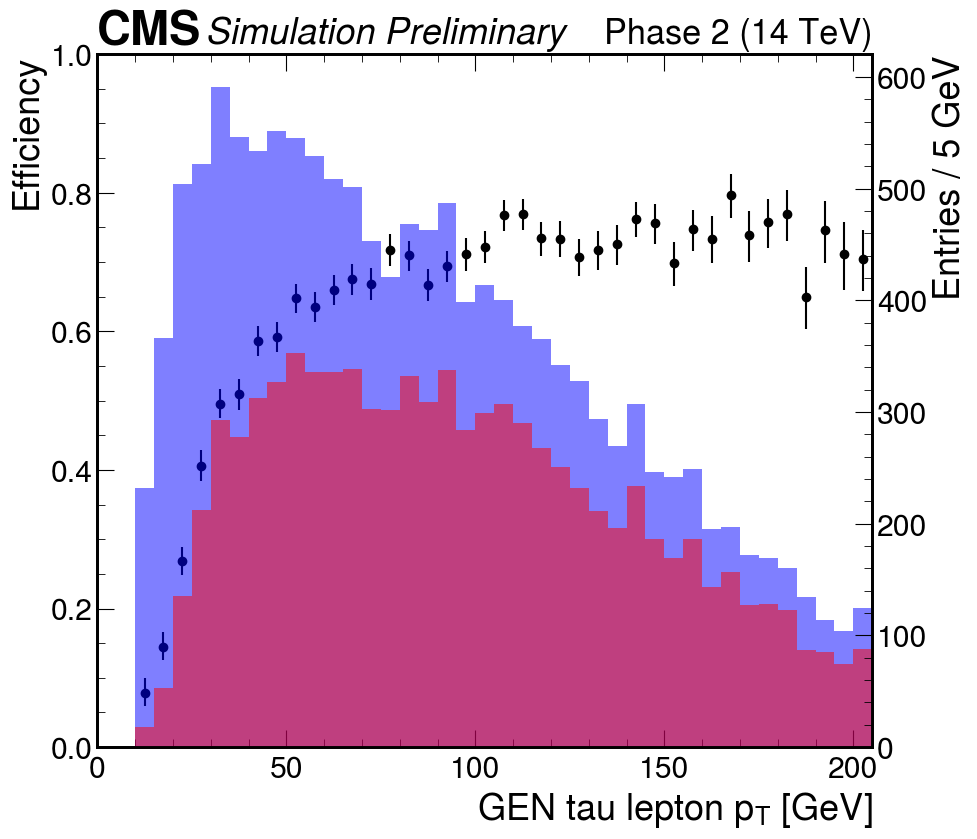

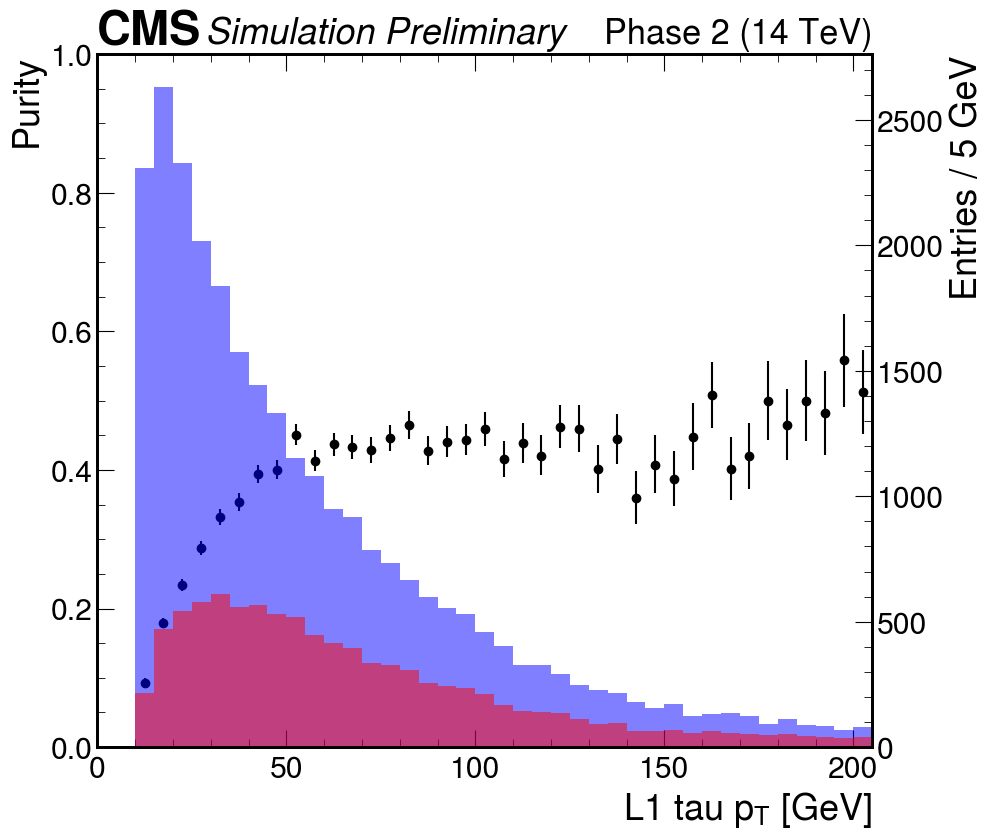

In [109]:
def selections_bbtautau_phase2(**kwargs):

    # Default settings
    nevents = kwargs["nevents"] if "nevents" in kwargs.keys() else 10000
    skip = kwargs["skip"] if "skip" in kwargs.keys() else 0
    verbosity = kwargs["verbosity"] if "verbosity" in kwargs.keys() else 0
    gen_pt_min = kwargs["gen_pt_min"] if "gen_pt_min" in kwargs.keys() else 10.
    gen_eta_max = kwargs["gen_eta_max"] if "gen_eta_max" in kwargs.keys() else 2.5
    off_pt_min = kwargs["off_pt_min"] if "off_pt_min" in kwargs.keys() else 35.
    off_eta_max = kwargs["off_eta_max"] if "off_eta_max" in kwargs.keys() else 2.5
    off_btag_min = kwargs["off_btag_min"] if "off_btag_min" in kwargs.keys() else 0. #@@ DEFAULT IS ZERO ???
    sct_pt_min = kwargs["sct_pt_min"] if "sct_pt_min" in kwargs.keys() else 20.
    sct_eta_max = kwargs["sct_eta_max"] if "sct_eta_max" in kwargs.keys() else 2.5
    use_matched = kwargs["use_matched"] if "use_matched" in kwargs.keys() else False
    option = kwargs["option"] if "option" in kwargs.keys() else "bbtautau"

    events = load_data_bbtautau_phase2(nevents=nevents,skip=skip,verbosity=verbosity)

    if verbosity>=2:
        print()
        print("FULL DEBUG MODE!!!")
        print(" Verbosity: ", verbosity)
        print(" Num evts:  ", len(events["nGenPart"]))
    
    passed_GEN, gen = GEN_acceptance_bbtautau_phase2(events,pt_min=gen_pt_min,eta_max=gen_eta_max,verbosity=verbosity)
    passed_L1T = L1T_passing_bbtautau_phase2(events,passed=passed_GEN,option=option,verbosity=verbosity)
    matched_L1T = L1T_matching_bbtautau_phase2(events,gen,passed=passed_L1T,option=option,verbosity=verbosity) if use_matched else ak.full_like(passed_L1T,True,dtype=bool)
    passed_HLT = HLT_passing_bbtautau_phase2(events,passed=matched_L1T,option=option,verbosity=verbosity)
    matched_HLT = HLT_matching_bbtautau_phase2(events,gen,passed=passed_HLT,option=option,verbosity=verbosity) if use_matched else ak.full_like(passed_HLT,True,dtype=bool)
    matched_OFF = OFF_matching_bbtautau_phase2(events,gen,pt_min=off_pt_min,eta_max=off_eta_max,btag_min=off_btag_min,passed=matched_HLT,verbosity=verbosity)
    matched_SCT = SCT_matching_bbtautau_phase2(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    # Plotting (only plot once)
    if use_matched == False and option == "tautau":
        SCT_plot_eff_vs_tau_pt_bbtautau_phase2(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)
        SCT_plot_purity_vs_tau_pt_bbtautau_phase2(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    print_summary(
        events,
        passed_GEN=passed_GEN,
        passed_L1T=passed_L1T,
        matched_L1T=matched_L1T,
        passed_HLT=passed_HLT,
        matched_HLT=matched_HLT,
        matched_OFF=matched_OFF,
        matched_SCT=matched_SCT,
        use_matched=use_matched, # Use passed or matched for L1T and HLT
        )

# option="tautau"
print()
settings = settings_.copy()
settings.update({"option":"tautau"})
print(settings)
selections_bbtautau_phase2(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbtautau_phase2(**settings) 

# option="bb"
print()
settings = settings_.copy()
settings.update({"option":"bb"})
print(settings)
selections_bbtautau_phase2(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbtautau_phase2(**settings) 

# option="bbtautau"
print()
settings = settings_.copy()
settings.update({"option":"bbtautau"})
print(settings)
selections_bbtautau_phase2(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbtautau_phase2(**settings) 



## bbbb (Run 3, muon)

### LOAD

In [110]:
#############################################################################################
#
def load_data_bbbb_muon(nevents=None,skip=0,verbosity=0):

    # Open ROOT file with uproot
    example_file = "../data/nano_4b_run3.root"
    file = uproot.open(example_file)
    tree = file["Events"]

    if verbosity>=3:
        keys = tree.keys()
        print()
        print("[load_data_bbbb]")
        print("All branches:")
        for key in keys:
            print(f"  {key}")
        print()
        print("L1 seeds:")
        for key in keys:
            if key.startswith("L1_") : print(f"  {key}")
        print()
        print("HLT paths:")
        for key in keys:
            if key.startswith("HLT_") : print(f"  {key}")

    branches = [
        "GenPart_pt", "GenPart_eta", "GenPart_phi", # GEN-level kinematics
        "nGenPart","GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_statusFlags", # GEN-level information
        "L1_HTT280er", # L1 seeds
        "HLT_PFHT280_QuadPFJet30_PNet2BTagMean0p55", # HLT paths
        "nTrigObj", "TrigObj_pt", "TrigObj_eta", "TrigObj_phi", "TrigObj_id", "TrigObj_filterBits", # Trigger objects
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagPNetB", # Offline jets
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_dxy", "Muon_dxyErr", # Offline muons
        "nL1Jet", "L1Jet_pt", "L1Jet_eta", "L1Jet_phi", # L1 jets 
        "nL1Mu", "L1Mu_pt", "L1Mu_eta", "L1Mu_phi", "L1Mu_etaAtVtx", "L1Mu_phiAtVtx", "L1Mu_hwQual",  # L1 muons
    ]

    # Load data into awkward arrays
    events = tree.arrays(branches, library="ak")
    events = events[skip:nevents+skip] if nevents is not None else events[skip:]
    return events


### ACC

In [111]:
#############################################################################################
#
def GEN_acceptance_bbbb_muon(events,pt_min,eta_max,verbosity=0):
    return GEN_acceptance_bbbb(events,pt_min=pt_min,eta_max=eta_max,verbosity=verbosity)

### L1T

In [112]:
#############################################################################################
#
def L1_SingleMu11_SQ14_BMTF(events):
    L1Mu = L1Mu_objects(events)
    L1Mu = L1Mu[(L1Mu.pt >= 11.) & (abs(L1Mu.eta) <= 0.8) & (L1Mu.qual >= 12)] #@@ HWQual >= 14 doesn't ever occur??
    return L1Mu

#############################################################################################
#
def L1T_passing_muon(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    #seed = "L1_SingleMu11_SQ14_BMTF" #@@ L1_SingleMu7_SQ14_BMTF, L1_SingleMu8_SQ14_BMTF, L1_SingleMu9_SQ14_BMTF, L1_SingleMu10_SQ14_BMTF
    #return L1T_passing(events,seed,verbosity=verbosity)
    emulate_L1T = L1_SingleMu11_SQ14_BMTF(events)
    passed_L1T = ak.num(emulate_L1T) > 0 
    return passed_L1T

#############################################################################################
#
def L1T_passing_bbbb_muon(events,passed=None,option=None,verbosity=0):
    if option == "muon":
        return L1T_passing_muon(events,passed=passed,verbosity=verbosity)
    elif option == "bbbb":
        return L1T_passing_bbbb(events,passed=passed,verbosity=verbosity)
    elif option == "bbbb_muon" or option is None:
        passed_L1T_muon = L1T_passing_muon(events,passed=passed,verbosity=verbosity)
        passed_L1T_bbbb = L1T_passing_bbbb(events,passed=passed,verbosity=verbosity)
        return passed_L1T_muon | passed_L1T_bbbb
        #return passed_L1T_muon & passed_L1T_bbbb
        #return passed_L1T_muon & ~passed_L1T_bbbb
        #return passed_L1T_bbbb & ~passed_L1T_muon 
    else:
        raise ValueError(f"Invalid option: {option}")

#############################################################################################
#
def L1T_matching_muon(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    #L1Mu = L1Mu_objects(events)
    #L1Mu = L1Mu[(L1Mu.pt > 10.) & (abs(L1Mu.eta) < 0.8) & (L1Mu.qual >= 12)] # HWQual > 14?
    L1Mu = L1_SingleMu11_SQ14_BMTF(events)
    matched_L1T = object_matching(
        gen,
        L1Mu,
        passed=passed,
        gen_id_filter=5,
        n=1, # Match muon to just one b-quark
        dr_max=0.3, #@@ Loose requirement
        dpt_min=None, dpt_max=None,
        verbosity=verbosity)
    return matched_L1T

#############################################################################################
#
def L1T_matching_bbbb_muon(events,gen,passed=None,option=None,verbosity=0):
    if option == "muon":
        return L1T_matching_muon(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bbbb":
        return L1T_matching_bbbb(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bbbb_muon" or option is None:
        matched_L1T_muon = L1T_matching_muon(events,gen,passed=passed,verbosity=verbosity)
        matched_L1T_bbbb = L1T_matching_bbbb(events,gen,passed=passed,verbosity=verbosity)
        return matched_L1T_muon | matched_L1T_bbbb
        #return matched_L1T_muon & matched_L1T_bbbb
        #return matched_L1T_muon & ~matched_L1T_bbbb
        #return matched_L1T_bbbb & ~matched_L1T_muon 
    else:
        raise ValueError(f"Invalid option: {option}")


### HLT

In [113]:
#############################################################################################
#
def HLT_Mu10_Barrel_L1HP11_IP6(events):
    muon = muon_objects(events)
    muon = muon[(muon.pt >= 10.) & (abs(muon.eta) <= 2.5) & (muon.dxysig >= 0.)]
    return muon

#############################################################################################
#
def HLT_passing_muon(events,passed=None,verbosity=0):
    events = filter_events(events,passed)
    #path = "HLT_Mu10_Barrel_L1HP11_IP6" #@@ HLT_Mu6_Barrel_L1HP7_IP6, HLT_Mu7_Barrel_L1HP8_IP6, HLT_Mu8_Barrel_L1HP9_IP6, HLT_Mu9_Barrel_L1HP10_IP6
    #return HLT_passing(events,path,verbosity=verbosity)
    emulate_HLT = HLT_Mu10_Barrel_L1HP11_IP6(events)
    passed_HLT = ak.num(emulate_HLT) > 0 
    return passed_HLT

#############################################################################################
#
def HLT_passing_bbbb_muon(events,passed=None,option=None,verbosity=0):
    if option == "muon":
        return HLT_passing_muon(events,passed=passed,verbosity=verbosity)
    elif option == "bbbb":
        return HLT_passing_bbbb(events,passed=passed,verbosity=verbosity)
    elif option == "bbbb_muon" or option is None:
        passed_HLT_muon = HLT_passing_muon(events,passed=passed,verbosity=verbosity)
        passed_HLT_bbbb = HLT_passing_bbbb(events,passed=passed,verbosity=verbosity)
        return passed_HLT_muon | passed_HLT_bbbb
        #return passed_HLT_muon & passed_HLT_bbbb
        #return passed_HLT_muon & ~passed_HLT_bbbb
        #return passed_HLT_bbbb & ~passed_HLT_muon 
    else:
        raise ValueError(f"Invalid option: {option}")

#############################################################################################
#
def HLT_matching_muon(events,gen,passed=None,verbosity=0):
    events = filter_events(events,passed)
    #muon = muon_objects(events)
    #muon = muon[(muon.pt > 9.) & (abs(muon.eta) < 0.8) & (muon.dxysig > 0.)]
    muon = HLT_Mu10_Barrel_L1HP11_IP6(events)

    # All 4 jets
    matched_HLT = object_matching(
        gen,
        muon,
        passed=passed,
        gen_id_filter=5, # b quarks only
        n=1,
        dr_max=0.3,
        dpt_min=None,dpt_max=None,
        verbosity=verbosity)

    return matched_HLT

#############################################################################################
#
def HLT_matching_bbbb_muon(events,gen,passed=None,option=None,verbosity=0):
    if option == "muon":
        return HLT_matching_muon(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bbbb":
        return HLT_matching_bbbb(events,gen,passed=passed,verbosity=verbosity)
    elif option == "bbbb_muon" or option is None:
        matched_HLT_muon = HLT_matching_muon(events,gen,passed=passed,verbosity=verbosity)
        matched_HLT_bbbb = HLT_matching_bbbb(events,gen,passed=passed,verbosity=verbosity)
        return matched_HLT_muon | matched_HLT_bbbb
        #return matched_HLT_muon & matched_HLT_bbbb
        #return matched_HLT_muon & ~matched_HLT_bbbb
        #return matched_HLT_bbbb & ~matched_HLT_muon 
    else:
        raise ValueError(f"Invalid option: {option}")


### OFF

In [114]:
#############################################################################################
#
def OFF_matching_muon(events,gen,pt_min,eta_max,btag_min=0.,passed=None,verbosity=0):
    events = filter_events(events,passed)

    # Extract jet info and filter to keep only those within acceptance
    jet = jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    matched_OFF_jets = object_matching(
        gen,
        jet,
        passed=passed,
        gen_id_filter=5,
        n=4,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )
    
    matched_OFF_bjets = object_matching(
        gen,
        jet[jet.btag >= btag_min], # Subset of jets that satisfy b-tagging requirement
        passed=passed,
        gen_id_filter=5,
        n=4,
        dr_max=0.3,dpt_min=0.2,dpt_max=2.0,
        verbosity=verbosity
        )
    
    muon = muon_objects(events)
    muon = muon[(muon.pt >= 10.) & (abs(muon.eta) <= 2.5) & (muon.dxysig >= 0.)]

    matched_OFF_muon = object_matching(
        gen,
        muon, 
        passed=passed,
        gen_id_filter=5,
        n=1, # Require muon to match one b quark
        dr_max=0.3,
        dpt_min=None,dpt_max=None,
        verbosity=verbosity
        )

    matched_OFF = matched_OFF_jets & matched_OFF_bjets & matched_OFF_muon

    return matched_OFF

#############################################################################################
#
def OFF_matching_bbbb_muon(events,gen,passed=None,option=None,verbosity=0):
    if option == "muon":
        pt_min, eta_max, btag_min = 20., 2.5, 0.
        return OFF_matching_muon(events,gen,pt_min,eta_max,btag_min=btag_min,passed=passed,verbosity=verbosity)
    elif option == "bbbb":
        pt_min, eta_max, btag_min = 35., 2.5, 0.
        return OFF_matching_bbbb(events,gen,pt_min,eta_max,btag_min=btag_min,passed=passed,verbosity=verbosity)
    elif option == "bbbb_muon" or option is None:
        pt_min, eta_max, btag_min = 20., 2.5, 0.
        matched_OFF_muon = OFF_matching_muon(events,gen,pt_min,eta_max,btag_min=btag_min,passed=passed,verbosity=verbosity)
        pt_min, eta_max, btag_min = 35., 2.5, 0.
        matched_OFF_bbbb = OFF_matching_bbbb(events,gen,pt_min,eta_max,btag_min=btag_min,passed=passed,verbosity=verbosity)
        return matched_OFF_muon | matched_OFF_bbbb
    else:
        raise ValueError(f"Invalid option: {option}")

### SCT

In [115]:
#############################################################################################
#
def SCT_matching_bbbb_muon(events,gen,pt_min,eta_max,passed=None,verbosity=0):

    events = filter_events(events,passed)
    
    # Extract L1 objects and filter to keep only those within acceptance
    jet = L1Jet_objects(events)
    jet["in_acc"] = (jet.pt > pt_min) & (abs(jet.eta) < eta_max)
    jet = jet[jet.in_acc]

    # tau = L1Tau_objects(events)
    # tau["in_acc"] = (tau.pt > pt_min) & (abs(tau.eta) < eta_max)
    # tau = tau[tau.in_acc]

    # Concatenate L1 jets and L1 taus
    # jet = ak.concatenate([jet,tau],axis=-1) #@@ NEED TO REMOVE OVERLAPPING JETS AND TAUS ??!!

    # Match either L1 jets or L1 taus
    matched_SCT = object_matching(
        gen,
        jet,
        passed=passed,
        gen_id_filter=5,
        n=4, 
        verbosity=verbosity)

    return matched_SCT

### EXECUTE

In [116]:
def selections_bbbb_muon(**kwargs):
    
    # Default settings
    nevents = kwargs["nevents"] if "nevents" in kwargs.keys() else 10000
    skip = kwargs["skip"] if "skip" in kwargs.keys() else 0
    verbosity = kwargs["verbosity"] if "verbosity" in kwargs.keys() else 0
    gen_pt_min = kwargs["gen_pt_min"] if "gen_pt_min" in kwargs.keys() else 10.
    gen_eta_max = kwargs["gen_eta_max"] if "gen_eta_max" in kwargs.keys() else 2.5
    off_pt_min = kwargs["off_pt_min"] if "off_pt_min" in kwargs.keys() else 35.
    off_eta_max = kwargs["off_eta_max"] if "off_eta_max" in kwargs.keys() else 2.5
    off_btag_min = kwargs["off_btag_min"] if "off_btag_min" in kwargs.keys() else 0. #@@ DEFAULT IS ZERO ???
    sct_pt_min = kwargs["sct_pt_min"] if "sct_pt_min" in kwargs.keys() else 20.
    sct_eta_max = kwargs["sct_eta_max"] if "sct_eta_max" in kwargs.keys() else 2.5
    use_matched = kwargs["use_matched"] if "use_matched" in kwargs.keys() else False
    option = kwargs["option"] if "option" in kwargs.keys() else "unknown"

    events = load_data_bbbb_muon(nevents=nevents,skip=skip,verbosity=verbosity)
    
    if verbosity>=2:
        print()
        print("FULL DEBUG MODE!!!")
        print(" Verbosity: ", verbosity)
        print(" Num evts:  ", len(events["nGenPart"]))
    
    passed_GEN, gen = GEN_acceptance_bbbb_muon(events,pt_min=gen_pt_min,eta_max=gen_eta_max,verbosity=verbosity)
    passed_L1T = L1T_passing_bbbb_muon(events,passed=passed_GEN,option=option,verbosity=verbosity)
    matched_L1T = L1T_matching_bbbb_muon(events,gen,passed=passed_L1T,option=option,verbosity=verbosity) if use_matched else ak.full_like(passed_L1T,True,dtype=bool)
    passed_HLT = HLT_passing_bbbb_muon(events,passed=matched_L1T,option=option,verbosity=verbosity)
    matched_HLT = HLT_matching_bbbb_muon(events,gen,passed=passed_HLT,option=option,verbosity=verbosity) if use_matched else ak.full_like(passed_HLT,True,dtype=bool)
    matched_OFF = OFF_matching_bbbb_muon(events,gen,passed=matched_HLT,option=option,verbosity=verbosity) #@@ pt_min, eta_max, and btag_min and set in the method itself for the different options!
    matched_SCT = SCT_matching_bbbb_muon(events,gen,pt_min=sct_pt_min,eta_max=sct_eta_max,passed=passed_GEN,verbosity=verbosity)

    print_summary(
        events,
        passed_GEN=passed_GEN,
        passed_L1T=passed_L1T,
        matched_L1T=matched_L1T,
        passed_HLT=passed_HLT,
        matched_HLT=matched_HLT,
        matched_OFF=matched_OFF,
        matched_SCT=matched_SCT,
        use_matched=use_matched, # Use passed or matched for L1T and HLT
        )


# NOTA BENE: "off_pt_min", "off_eta_max", and "off_btag_min" settings are OVERRIDDEN IN THE METHODS, differently for each option

# option="muon"
print()
settings = settings_.copy()
settings.update({"off_pt_min":None, "off_eta_max":None, "off_btag_min":None, })
settings.update({"option":"muon"})
print(settings)
selections_bbbb_muon(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbbb_muon(**settings) 

# option="bbbb"
print()
settings = settings_.copy()
settings.update({"off_pt_min":None, "off_eta_max":None, "off_btag_min":None, })
settings.update({"option":"bbbb"})
print(settings)
selections_bbbb_muon(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbbb_muon(**settings) 

# option="bbbb_muon"
print()
settings = settings_.copy()
settings.update({"off_pt_min":None, "off_eta_max":None, "off_btag_min":None, })
settings.update({"option":"bbbb_muon"})
print(settings)
selections_bbbb_muon(**settings) 
settings.update({"use_matched":True})
print(settings)
selections_bbbb_muon(**settings) 



{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': None, 'off_eta_max': None, 'off_btag_min': None, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'muon', 'use_matched': False}

              Events    Eff   Gain
STANDARD (No matching @ L1 & HLT)
Inclusive      10000 
Acceptance      6368   0.64   0.23
L1T             1157   0.12   1.27
HLT              667   0.07   2.20
Offline          228   0.02   6.44
----------------------------------
SCOUTING
Inclusive      10000
Acceptance      6368   0.64
Scouting        1468   0.15
{'debug': False, 'nevents': 10000, 'skip': 0, 'verbosity': 0, 'gen_pt_min': 10.0, 'gen_eta_max': 2.5, 'off_pt_min': None, 'off_eta_max': None, 'off_btag_min': None, 'sct_pt_min': 10.0, 'sct_eta_max': 2.5, 'option': 'muon', 'use_matched': True}

              Events    Eff   Gain
STANDARD (W/ matching @ L1 & HLT)
Inclusive      10000 
Acceptance      6368   0.64   0.23
L1T             1082   0.11   